In [111]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import os
import math

from scipy.stats import ttest_ind
from scipy.stats import ttest_rel
import scipy.stats as stats

import csv

#from mpltools import special ##leon

# for 3d plot
#import numpy as np
#import matplotlib.pyplot as plt
from matplotlib import cm
#from mpl_toolkits.mplot3d import Axes3D

#plt.style.use('seaborn-poster')
#plt.style.use('fivethirtyeight')
#plt.style.use('grayscale')
#plt.style.use('seaborn-colorblind')


# DEFINE DATA CLASS
class RawData(object):
    def __init__(self,timestamp,keytime,ttime,keypress,targetid,target_lon,target_lat,target_x,target_y,target_z,hmd_rx,hmd_ry,hmd_rz):
        self.timestamp=timestamp # 1 (default time?)
        self.keytime=keytime # 2 +Time.deltaTime
        self.ttime=ttime # 3 Time.time
        self.keypress=keypress # 4
        self.targetid=targetid # 5
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.target_x=target_x
        self.target_y=target_y
        self.target_z=target_z
        self.hmd_rx=hmd_rx # 11
        self.hmd_ry=hmd_ry # 12
        self.hmd_rz=hmd_rz # 13

class TimeData(object):
    def __init__(self,targetid,target_lon,target_lat,deltatime):
        self.targetid=targetid
        self.target_lon=target_lon
        self.target_lat=target_lat
        self.deltatime=deltatime


LAT_KEY = ('-30','0','30')
LON_KEY = ('0','30','60','90','120','150','180')
LAT_KEY_F = (-30,0,30)
LON_KEY_F = (0,30,60,90,120,150,180)
    
    
class User(object):
    def __init__(self, lat, lon, user, test):
        self.lat=lat
        self.lon=lon
        self.user=user
        self.test=test
        self.speed_array = [[] for x in range(5)]
        self.time_array = [[] for x in range(5)]
        self.speed_raw = [[] for x in range(5)]
        self.time_raw = [[] for x in range(5)]
        self.speed_mean = [[] for x in range(5)]
        self.speed_std = [[] for x in range(5)]
        self.time_mean = [[] for x in range(5)]
        self.time_std = [[] for x in range(5)]
        
        self.time_median = [[] for x in range(5)]
        self.speed_median = [[] for x in range(5)]
        #print(np.array(self.speed_array).shape)
        
        self.round_array = []
        self.round_data = [[] for x in range(5)]
        


        
    ## READ DATA
    def _read_data(self, file):
        raw_data=[]
        print("Reading %s"%file)
        seperator="\t"
        with open(file,"r") as fp:
            for line in fp:
                if line.startswith("Time"):
                    continue     ## Skip the Header
                l=line[:-1]   ## Delete the Last Element then Return
                f=l.split(seperator)   ## Divide the Raw Data to Pieces
                if(int(f[3])==1):   ## 4.When Finish Targeting and Press Key
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),float(f[5]),float(f[6]),float(f[7]),float(f[8]),float(f[9]),float(f[10]),float(f[11]),float(f[12])))
                else: 
                    raw_data.append(RawData(f[0],float(f[1]),float(f[2]),float(f[3]),float(f[4]),0,0,0,0,0,float(f[10]),float(f[11]),float(f[12])))

        return raw_data



    # Input Raw Data, Each Tester, return aim_time[[[,,,],,,,,][,,,,,][,,,,,]] 3-layer array
    # Every Target Aiming Time in aim_time[lat][lon] = [first, second, third]
    def _aim_time_filter(self, input_raw_data):
        aim_time={}
        filtered_data=[a for a in input_raw_data if a.keypress==1]

        for i in range(len(filtered_data)-1):
            if(filtered_data[i+1].targetid!=filtered_data[i].targetid):
                continue # when resuming back
            if((i <= (len(filtered_data)-3)) and (filtered_data[i-1].targetid==filtered_data[i+2].targetid)):
                continue # when two same targets appear one after one
            delta_time=filtered_data[i+1].ttime-filtered_data[i].ttime
            #print(delta_time, filtered_data[i].targetid)

            key1=str(int(filtered_data[i].target_lat))
            key2=str(int(filtered_data[i].target_lon))
            if(key1 in aim_time)==False:
                aim_time[key1]={}
            if(key2 in aim_time[key1])==False:
                aim_time[key1][key2]=[]

            aim_time[key1][key2].append(TimeData(filtered_data[i].targetid,filtered_data[i].target_lon,filtered_data[i].target_lat,delta_time))

        aim_time[str(0)][str(0)]=[]   # Special (0,0) Not Exist but for data processing, add a pseudo datum
        aim_time[str(0)][str(0)].append(TimeData(float(21),float(0),float(0),float(0)))

        return aim_time   # aim_time is 3*3*7 array{}

    LAT_KEY = ('-30','0','30')
    LON_KEY = ('0','30','60','90','120','150','180')

    def _extract_time(self, input_time):
        #lat = [a for a in input_time]
        #lon = [b for b in input_time[lat]]
        #target = [c.deltatime for c in input_time[lon] ]
        
        time_dict = {}
        #time_flat = [] # not useful, not sorted
        
        lat_order = ['-30','0','30']
        lon_order = ['0','30','60','90','120','150','180']
        
        for lat in lat_order:
            time_dict[lat] ={}
            #time_lon = []
            for lon in lon_order:
                time_dict[lat][lon] = [target.deltatime for target in input_time[lat][lon]]
                #time_target = [target.deltatime for target in input_time[lat][lon]]
                #time_lon.append(time_target)
            #time_flat.append(time_lon)

        return time_dict#, time_flat
    
    def _cal_round(self, input_time_dict, test):
        r=[[],[],[],[]]
        #print(input_time_dict)
        for lat in input_time_dict:
            for lon in input_time_dict[lat]:
                if ((lon=='0') and (lat=='0')):
                    continue
                for i in range(4):
                    #print("lat", lat, "lon", lon, "i", i, "value", input_time_dict[lat][lon][i])
                    if (i >= len(input_time_dict[lat][lon])):
                        print("Round "+str(i+1)+"("+lat+","+lon+" Not Enough Data")
                        #r[i].append(input_time_dict[lat][lon][-1])
                        r[i].append(np.mean(input_time_dict[lat][lon]))
                    else:
                        r[i].append(input_time_dict[lat][lon][i])
                    

                
        self.round_array = [np.sum(r[0]), np.sum(r[1]), np.sum(r[2]), np.sum(r[3])]
        
        #print(round_array)
        if (False):
            fig,ax=plt.subplots()
            width = 0.6
            plt.bar(range(4), self.round_array, width, label='Round Time', color="G")
            plt.title('Test '+ str(test))
            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")      
            plt.show()
        
        return self.round_array

    def _flatten_data(self, input_data):
        
        flat_data = []
        
        for lat in input_data:
            data_lon = []
            for lon in input_data[lat]:
                data_target = [target for target in input_data[lat][lon]]
                data_lon.append(data_target)
            flat_data.append(data_lon)
        
        return flat_data
    
    def _time_to_speed(self, input_time):
        
        speed={}
        
        for lat in input_time:
            speed[lat]={}
            for lon in input_time[lat]:
                speed[lat][lon]=[]
                for target in range(len(input_time[lat][lon])):
                    if (input_time[lat][lon][target]==0):
                        #r.append(0) # speed = 0
                        speed[lat][lon].append(0)
                        continue
                    
                    angle = User._angle_ac(self, int(lat), int(lon))
                    speed[lat][lon].append( angle / input_time[lat][lon][target] )

        return speed    # 3*3*7 array{}

    def _angle_ap(self, lat, lon):
        angle = math.sqrt( lat**2 + lon**2 )
        return angle

    def _angle_ac(self, lat, lon):
        angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
        return angle

    # Calculate the Mean and STD
    def _dict_stat(input_dict): # return

        key1=['-30','0','30']    # 3 lat
        if (len(input_dict) == 1):
            key1=['0']    # 1 lat
        key2=[0,30,60,90,120,150,180]
        
        #key3= [lat for lat in input_dict]
        #key4= [lon for lon in input_dict[key3[0]]]
        key3 = input_dict.keys()
        key4 = input_dict['0'].keys()
    
        if (tuple(input_dict.keys()) != User.LAT_KEY):
            print('Error may happen')
        
        target_mean={}
        target_std={}
        for lat in input_dict:
            target_mean[lat]={}
            target_std[lat]={}
            for lon in input_dict[lat]:
                if(input_dict[lat][lon]==[0]):
                #if(k2==0):
                    target_mean[lat][lon]=0
                    target_std[lat][lon]=0
                    continue
                
                target_mean[lat][lon]=np.mean(input_dict[lat][lon])
                target_std[lat][lon]=np.std(input_dict[lat][lon])

        return target_mean, target_std    # 3*7 array[]

    def _list_stat(input_data): # return
        
        #print(np.array(input_data).shape)
            
        target_mean=[]
        target_std=[]
        target_median=[]
        
        #for lon in range(len(input_data)):
        for lat in range(3):
            mean=[]
            std=[]
            median=[]
            #for lat in range(len(input_data[lon])):
            for lon in range(7):
                #if(lon==1 and lat==0):
                #if(k2==0):
                if (input_data[lat][lon] == [0]):
                    mean.append(0)
                    std.append(0)
                    median.append(0)
                    continue
                data = [target for target in input_data[lat][lon]]
                mean.append(np.mean(data))
                std.append(np.std(data))
                
                #data.sort();
                #if (len(data)>2):
                #    median.append(np.mean(data[1:-1]))
                #elif (len(data)==2):
                #    median.append((data[0]+data[1])*0.5)
                #else:
                #    median.append(data[0])
                median.append(np.median(data))
                        
    
            target_mean.append(mean)
            target_std.append(std)
            target_median.append(median)

        return target_mean, target_std, target_median    # 3*7 array[]


    def add_test(self, test, file):
        raw_data = User._read_data(self, file)
        aim_time = User._aim_time_filter(self, raw_data)
        time_dict = User._extract_time(self, aim_time)
        
        self.round_data[test-1] = User._cal_round(self, time_dict, test)##
        
        time_flat = User._flatten_data(self, time_dict)
        speed_dict = User._time_to_speed(self, time_dict)
        speed_flat = User._flatten_data(self, speed_dict)
        
        #self.speed_array.append(np.array(speed_flat))
        self.time_array[test-1] = time_flat
        self.speed_array[test-1] = speed_flat
        #self.time_raw.append(time_dict)
        self.time_raw[test-1] = time_dict
        self.speed_raw[test-1] = speed_dict
        
        #### mean or median here
        
        self.time_mean[test-1], self.time_std[test-1], self.time_median[test-1] = User._list_stat(time_flat)
        self.speed_mean[test-1], self.speed_std[test-1], self.speed_median[test-1] = User._list_stat(speed_flat)
        
        #self.time_mean = User._dict_stat
    
    def dict_print(dict_to_print):
        for x in dict_to_print:
            print ('--', x, '--')
            for y in dict_to_print[x]:
                print (y,':', dict_to_print[x][y])
                
    #def _mean(self, array):
    
    def cal_ratio(before, after):
        
        ratio=[]
        log=[]
        
        for i in range(len(before)):
            r=[]
            l=[]
            #print(len(before[i]))
            for j in range(len(before[i])):
                if(after[i][j]==0):
                    r.append(1) #ratio
                    l.append(0) #log
                    continue
                r.append( after[i][j] / before[i][j] ) #ratio
                l.append( math.log2( after[i][j] / before[i][j] ) ) #log
                #print(i,j,mean_after[i][j],mean_before[i][j])
            ratio.append(r)
            log.append(l)
            
        #print(np.array(ratio).shape)
        #print(np.array(log).shape)
        return ratio, log
    
    def ratio_of(self, data_type, average_type, before, after):
        if (data_type == 'time'):
            if (average_type == 'mean'):
                data_before = self.time_mean[before-1]
                data_after = self.time_mean[after-1]
            if (average_type == 'median'):
                data_before = self.time_median[before-1]
                data_after = self.time_median[after-1]
                
        if (data_type == 'speed'):
            if (average_type == 'mean'):
                data_before = self.speed_mean[before-1]
                data_after = self.speed_mean[after-1]
            if (average_type == 'median'):
                data_before = self.speed_median[before-1]
                data_after = self.speed_median[after-1]
            
        
        #print(np.array(self.speed_mean).shape)
        
        #print(np.array(self.speed_mean[before-1]).shape, np.array(data_before).shape)
        ratio0, log0 = User.cal_ratio(data_before, data_after)
        return ratio0, log0
            
        
        




class Exp(object):
    def __init__(self, _test_order, _user_order, _lat, _lon):
        self._test_order=_test_order
        self.lat=_lat
        self.lon=_lon
        self.user_order = _user_order
        
        self.time_mean_10x3x7 = [] #10*3*7
        self.time_mean_3x7x10 = [] #3*7*10
        self.time_mean_3x7 = [] #3*7
        self.time_std_3x7 = []
        self.time_std_3x7 = []
        self.time_mean_lon = [] #7
        self.time_mean_lat = [] #3
        self.time_mean_overall = 0 #1
        
        self.time_median_10x3x7 = [] #10*3*7
        
        self.speed_mean_10x3x7 = [] #10*3*7
        self.speed_mean_3x7x10 = [] #3*7*10
        self.speed_mean_3x7 = [] #3*7
        self.speed_std_3x7 = []
        self.speed_mean_lon = [] #7
        self.speed_mean_lat = [] #3
        self.speed_mean_overall = 0 #1
        
        self.speed_median_10x3x7 = [] #10*3*7
        
        self.no_user=True
        
        self.round_10x4 = []
        
        
        
    def add_user(self, temp_user):
        #print('temp_user.time_array',temp_user.time_array[self._test_order-1])
        #print('self.data_group',np.array(self.data_group))
        self.time_mean_10x3x7.append(temp_user.time_mean[self._test_order-1])
        self.time_median_10x3x7.append(temp_user.time_median[self._test_order-1])
        
        self.speed_mean_10x3x7.append(temp_user.speed_mean[self._test_order-1])
        self.speed_median_10x3x7.append(temp_user.speed_median[self._test_order-1])
        
        self.round_10x4.append(temp_user.round_data[self._test_order-1])
    
    
    def _deform(input_data):
        result=[]
        for lat in range(3):
            r=[]
            for lon in range(7):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                r.append(all_user)
            result.append(r)
        
        return result
    
    
    def _cal_mean_3x7(input_data):
        mean=[]
        std=[]
        for lat in range(3):
            m=[]
            s=[]
            for lon in range(7):
                all_user=[]
                for user in range(len(input_data)):
                    all_user.append(input_data[user][lat][lon])
                m.append(np.mean(all_user)) # *7
                s.append(np.std(all_user))
            mean.append(m)
            std.append(s)# *3
            
        return mean, std
    
    
    def _cal_mean_1(input_data):
        #print(np.array(input_data))
        data = [i for i in np.array(input_data).flatten() if (i!=0)]
        #print(np.array(input_data).flatten())
        #mean = np.mean(np.delete(np.array(input_data), 7))
        #std = np.std(np.delete(np.array(input_data), 7))
        mean = np.mean(data)
        std = np.std(data)
            
        return mean
    
    
    def cal_mean_3_old(input_data): # input 3*7
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[1] = np.mean(input_data[1][1:]) # lat=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std(input_data[1][1:]) # lat=0
        
        return mean, std
    
    def cal_mean_3(input_data): # input 10*3*7
        mean=[]
        std=[]
        for lat in range(3):
            data=[]
            
            for user in range(len(input_data)):  
                for lon in range(7):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
    
    
    def cal_mean_7_old(input_data_raw): # input 3*7
        input_data = np.array(input_data_raw).T
        mean = [np.mean(input_data[i]) for i in range(len(input_data))]
        mean[0] = np.mean([input_data[0][0],input_data[0][2]]) # lon=0
        
        std = [np.std(input_data[i]) for i in range(len(input_data))]
        std[1] = np.std([input_data[0][0],input_data[0][2]])# lat=0
        
        return mean, std
    
    def cal_mean_7(input_data): # input 10*3*7
        mean=[]
        std=[]
        #for lat in range(3):
        for lon in range(7):
            data=[]
            
            for user in range(len(input_data)):  
                #for lon in range(7):
                for lat in range(3):
                    if (input_data[user][lat][lon] == 0):
                        continue
                    data.append(input_data[user][lat][lon])
                    
            mean.append(np.mean(data)) 
            std.append(np.std(data))
        
        return mean, std
        
    
    def cal_mean(self):
        self.time_mean_3x7, self.time_std_3x7 = Exp._cal_mean_3x7(self.time_median_10x3x7)  #####median/mean
        self.time_mean_overall = Exp._cal_mean_1(self.time_median_10x3x7)                  #####median/mean
        
        self.speed_mean_3x7, self.speed_std_3x7 = Exp._cal_mean_3x7(self.speed_median_10x3x7) #####median/mean
        self.speed_mean_overall = Exp._cal_mean_1(self.speed_median_10x3x7)

        #self.time_mean_overall = np.mean(np.delete(np.array(self.time_mean_3x7), 7))
        #std
        #self.speed_mean_overall = np.mean(np.delete(np.array(self.speed_mean_3x7), 7))
        
        #self.time_mean_lat = [np.mean(self.time_mean_3x7[i]) for i in range(len(self.time_mean_3x7))]
        #self.time_mean_lat[1] = np.mean(self.time_mean_3x7[1][1:]) # lat=0
        #temp = np.transpose(self.time_mean_3x7)
        #self.time_mean_lon = [np.mean(temp[i]) for i in range(len(temp))]
        #self.time_mean_lon[0] = np.mean([temp[0][0],temp[0][2]]) # lon=0


In [112]:
def plot_single_user(which_type, input_data):
    
    data = input_data
    lon_key = [a for a in User.LON_KEY]
    lon_key.pop(0)
    
    data_short = [a for a in data[1]]
    data_short.pop(0)
    plt.plot()
    
    plt.plot(User.LON_KEY, data[0], '-v', label="-30")
    plt.plot(lon_key, data_short, '-o', label="0")
    plt.plot(User.LON_KEY, data[2], '-^', label="30")
    
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_axisbelow(True)
    
    if (which_type=='ratio'):
        ax.set_ylim(0,2)
        ax.set_title('Ratio')
        plt.ylabel('Ratio Value')
    if (which_type=='log'):
        ax.set_ylim(-1,1)
        ax.set_title('Log')
        plt.ylabel('Log Value')
    
    plt.legend(title="Latitude", loc=2)
    #plt.ylabel(kind2 + kind1)
    plt.xlabel('Target Longitude')
    plt.show()
    
    


Reading ../Users/1/1.txt
Round 4(0,90 Not Enough Data
Reading ../Users/1/2.txt


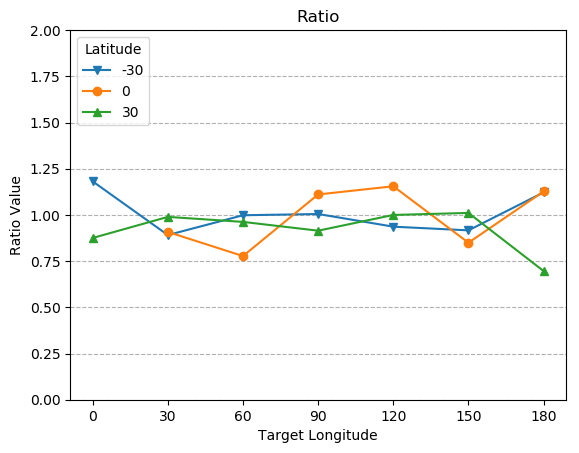

(3, 7)
Reading ../Users/2/1.txt
Reading ../Users/2/2.txt


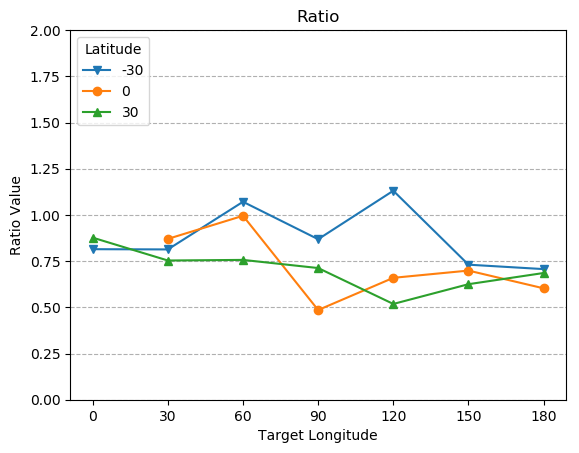

(3, 7)
Reading ../Users/3/1.txt
Reading ../Users/3/2.txt


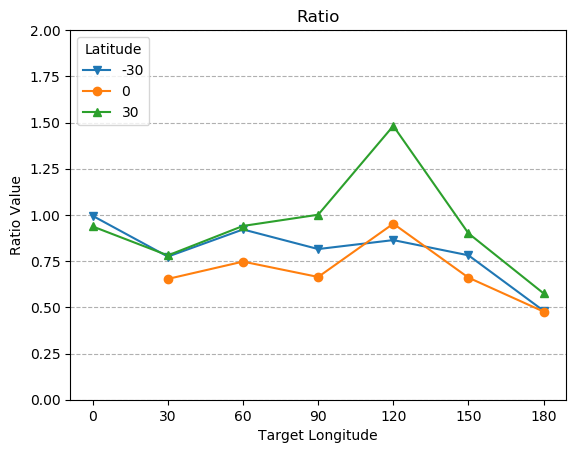

(3, 7)
Reading ../Users/4/1.txt
Round 4(30,30 Not Enough Data
Reading ../Users/4/2.txt


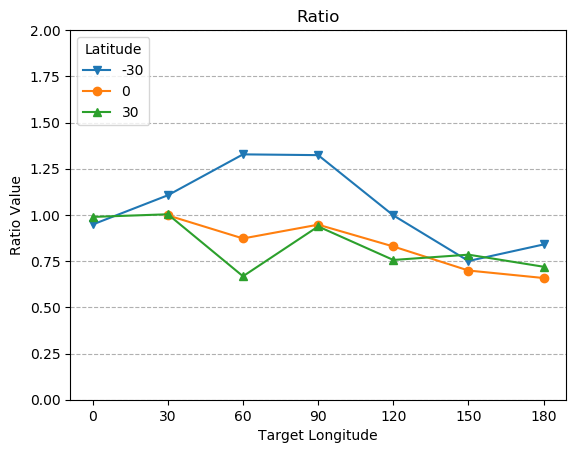

(3, 7)
Reading ../Users/5/1.txt
Reading ../Users/5/2.txt
Round 4(30,0 Not Enough Data


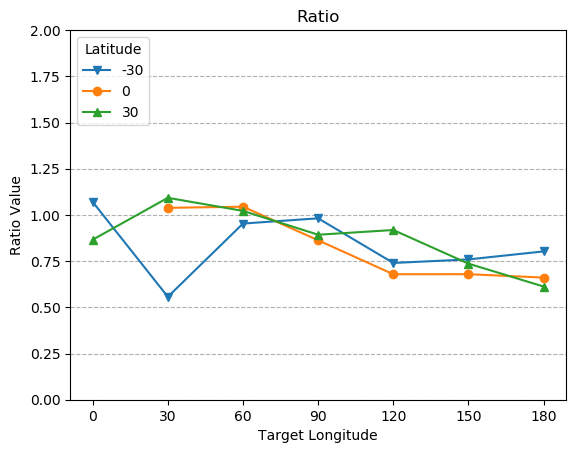

(3, 7)
Reading ../Users/9/1.txt
Round 3(-30,0 Not Enough Data
Round 4(-30,0 Not Enough Data
Round 4(-30,30 Not Enough Data
Round 4(-30,60 Not Enough Data
Round 3(-30,90 Not Enough Data
Round 4(-30,90 Not Enough Data
Round 3(-30,120 Not Enough Data
Round 4(-30,120 Not Enough Data
Round 3(-30,150 Not Enough Data
Round 4(-30,150 Not Enough Data
Round 3(-30,180 Not Enough Data
Round 4(-30,180 Not Enough Data
Round 3(0,30 Not Enough Data
Round 4(0,30 Not Enough Data
Round 3(0,60 Not Enough Data
Round 4(0,60 Not Enough Data
Round 3(0,90 Not Enough Data
Round 4(0,90 Not Enough Data
Round 4(0,120 Not Enough Data
Round 3(0,150 Not Enough Data
Round 4(0,150 Not Enough Data
Round 4(0,180 Not Enough Data
Round 3(30,0 Not Enough Data
Round 4(30,0 Not Enough Data
Round 3(30,30 Not Enough Data
Round 4(30,30 Not Enough Data
Round 3(30,60 Not Enough Data
Round 4(30,60 Not Enough Data
Round 3(30,90 Not Enough Data
Round 4(30,90 Not Enough Data
Round 3(30,120 Not Enough Data
Round 4(30,120 Not Enough Dat

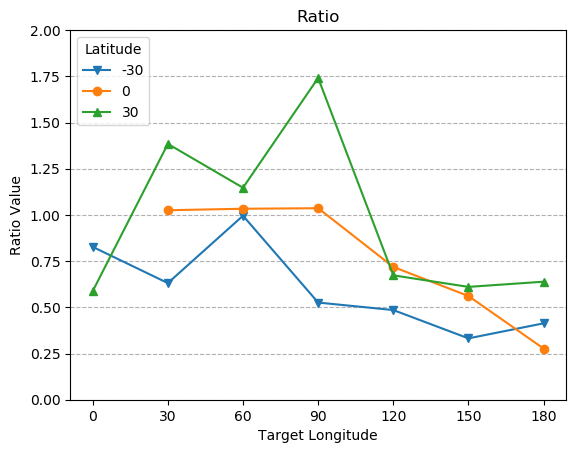

(3, 7)
Reading ../Users/10/1.txt
Reading ../Users/10/2.txt


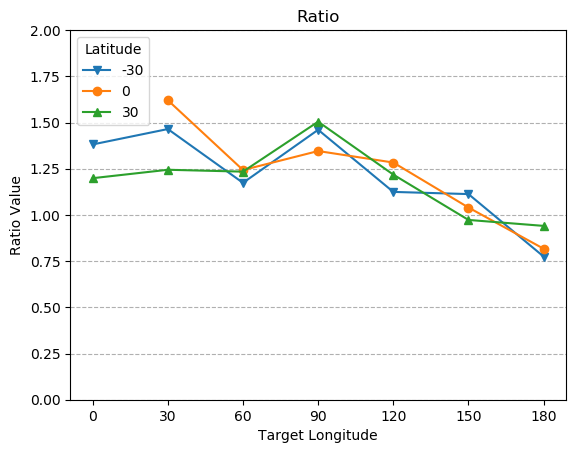

(3, 7)
Reading ../Users/14/1.txt
Reading ../Users/14/2.txt


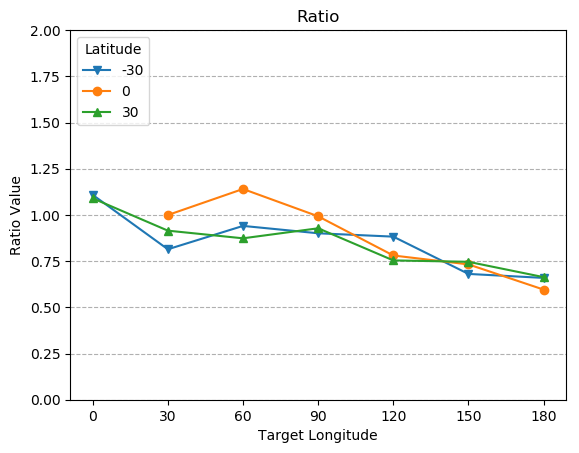

(3, 7)
Reading ../Users/6/1.txt
Reading ../Users/6/2.txt
Round 4(-30,120 Not Enough Data


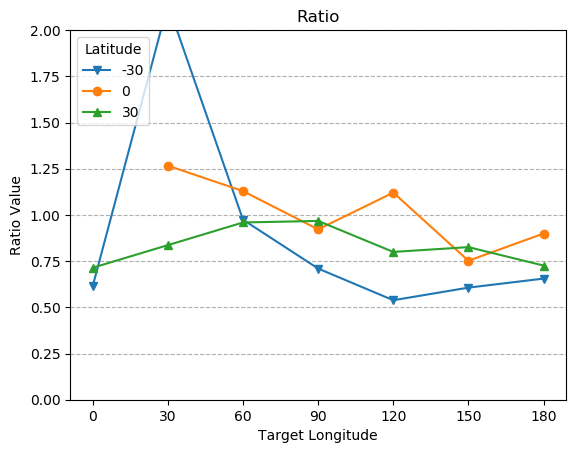

(3, 7)
Reading ../Users/12/1.txt
Reading ../Users/12/2.txt


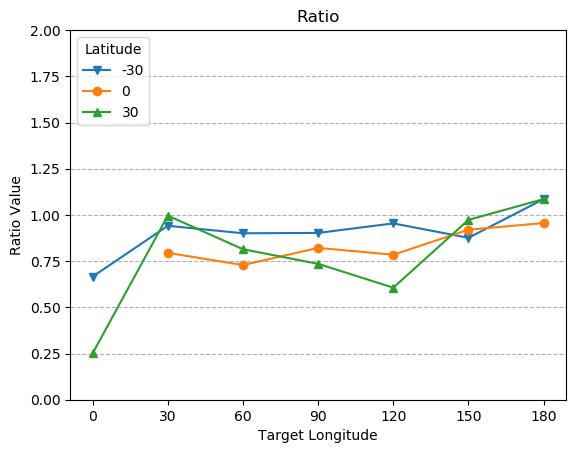

(3, 7)
Reading ../Users/13/1.txt
Round 4(0,60 Not Enough Data
Reading ../Users/13/2.txt


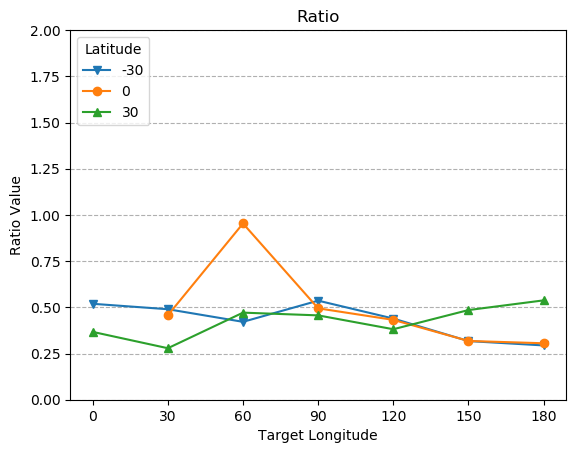

(3, 7)
Reading ../Users/8/1.txt
Round 3(-30,0 Not Enough Data
Round 4(-30,0 Not Enough Data
Round 3(-30,30 Not Enough Data
Round 4(-30,30 Not Enough Data
Round 3(-30,60 Not Enough Data
Round 4(-30,60 Not Enough Data
Round 3(-30,90 Not Enough Data
Round 4(-30,90 Not Enough Data
Round 3(-30,120 Not Enough Data
Round 4(-30,120 Not Enough Data
Round 3(-30,150 Not Enough Data
Round 4(-30,150 Not Enough Data
Round 3(-30,180 Not Enough Data
Round 4(-30,180 Not Enough Data
Round 3(0,30 Not Enough Data
Round 4(0,30 Not Enough Data
Round 3(0,60 Not Enough Data
Round 4(0,60 Not Enough Data
Round 3(0,90 Not Enough Data
Round 4(0,90 Not Enough Data
Round 3(0,120 Not Enough Data
Round 4(0,120 Not Enough Data
Round 3(0,150 Not Enough Data
Round 4(0,150 Not Enough Data
Round 3(0,180 Not Enough Data
Round 4(0,180 Not Enough Data
Round 4(30,0 Not Enough Data
Round 3(30,30 Not Enough Data
Round 4(30,30 Not Enough Data
Round 3(30,60 Not Enough Data
Round 4(30,60 Not Enough Data
Round 3(30,90 Not Enough Da

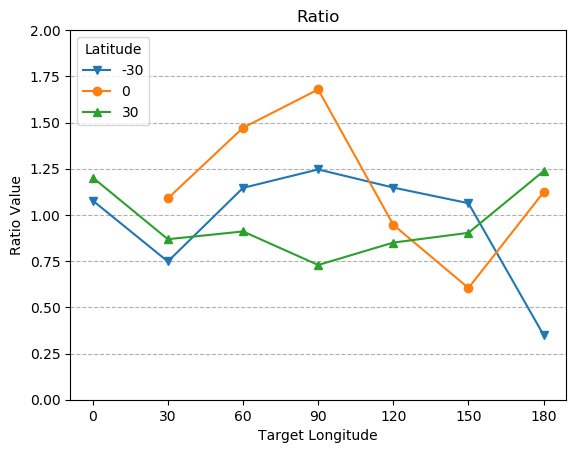

(3, 7)
Reading ../Users/11/1.txt
Round 4(30,60 Not Enough Data
Reading ../Users/11/2.txt
Round 4(-30,150 Not Enough Data


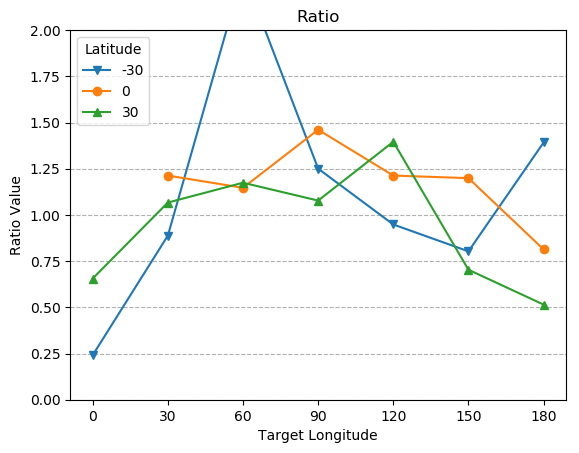

(3, 7)
Reading ../Users/7/1.txt
Round 3(-30,0 Not Enough Data
Round 4(-30,0 Not Enough Data
Round 2(-30,30 Not Enough Data
Round 3(-30,30 Not Enough Data
Round 4(-30,30 Not Enough Data
Round 3(-30,60 Not Enough Data
Round 4(-30,60 Not Enough Data
Round 3(-30,90 Not Enough Data
Round 4(-30,90 Not Enough Data
Round 4(-30,120 Not Enough Data
Round 3(-30,150 Not Enough Data
Round 4(-30,150 Not Enough Data
Round 3(-30,180 Not Enough Data
Round 4(-30,180 Not Enough Data
Round 3(0,30 Not Enough Data
Round 4(0,30 Not Enough Data
Round 3(0,60 Not Enough Data
Round 4(0,60 Not Enough Data
Round 3(0,90 Not Enough Data
Round 4(0,90 Not Enough Data
Round 3(0,120 Not Enough Data
Round 4(0,120 Not Enough Data
Round 3(0,150 Not Enough Data
Round 4(0,150 Not Enough Data
Round 3(0,180 Not Enough Data
Round 4(0,180 Not Enough Data
Round 3(30,0 Not Enough Data
Round 4(30,0 Not Enough Data
Round 3(30,30 Not Enough Data
Round 4(30,30 Not Enough Data
Round 3(30,60 Not Enough Data
Round 4(30,60 Not Enough Data

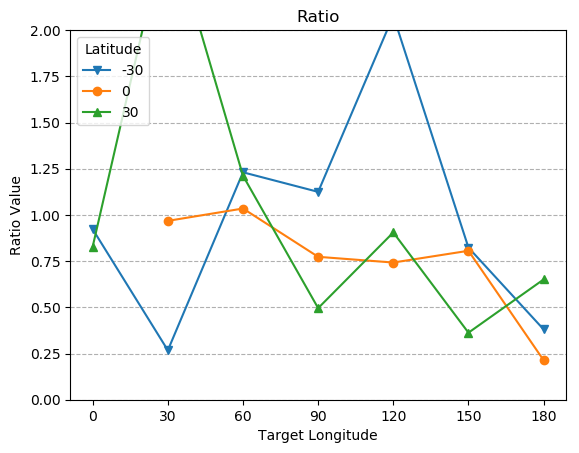

(3, 7)
[list([1, 2]) list([1, 2, 3])]


In [113]:
###################### choose user
users=[1,2,3,4,5,9,10,14,6,12,13,8,11,7]#after 13
#users=[1,2,3,4,5,9,10,14,6,11] # remove 7,8,9 with only two round 8,13 with exception 12
#users=[1,2,3,4,5,9,10,14,6,12]
#users=[1,2,3,4,5,6,8,9,10,12] #roshan
#users=[14,16,17,18,19,15]
#users=[1,2]
######################

    


user_all = [] 
test1 = Exp(1,1,1,1)
test2 = Exp(2,1,1,1)

for uid in range(len(users)):
    baseFolder=str(users[uid])
    #idx=[3,4,5]
    test_id=[1,2]

    #baseFolder = "1"
    #raw_data = read_data("../Users/"+baseFolder+"/"+str(idx[0])+".txt")

    user_temp = User(1,1,uid,1)
    #print(user_temp.time_raw[0])
    #print('!')
    for idx in range(len(test_id)):
        user_temp.add_test(test_id[idx],"../Users/"+baseFolder+"/"+str(test_id[idx])+".txt")
    
    test1.add_user(user_temp)
    test2.add_user(user_temp)
    
    #test3.add_user(user_temp)
    #test4.add_user(user_temp)
    #test5.add_user(user_temp)
    
    user_all.append(user_temp)
    #print(np.array(Test1.data_group).shape)
    #print('!')

    
    #User.dict_print(user_all[0].time_raw[0])
    #User.dict_print(user_all[1].time_raw[1])

    #print(np.array(user_all[1].time_mean[0]).shape)
    ratio, log = user_temp.ratio_of('time', 'mean',1,2)
    ratio_med, log_med = user_temp.ratio_of('time', 'median',1,2)
    #print(np.array(ratio).shape)
    
    #####plot_single_user('ratio', ratio)
    plot_single_user('ratio', ratio)
    #plot_single_user('log', log_med)
    print(np.array(ratio).shape)
    #plot_single_user(log)
    
    


array1 = np.array([[1,2],[1,2,3]])
print(array1)




In [124]:
export_order=1

def export_img(y_title):
    global export_order
    #plt.savefig('output/'+str(export_order)+'_'+y_title+'.pdf', dpi=300)
    export_order += 1

In [125]:
plt.style.use('default')

Exp.cal_mean(test1)
Exp.cal_mean(test2)

def remove_zero(input_data):
        data_new = list(input_data)[:]
        if (0 in input_data):         
            data_new.remove(0.)
        return data_new
    
def remove_one(input_data):
        data_new = list(input_data)[:]
        if (1. in input_data):         
            data_new.remove(1.)
        return data_new
    
def which_axis(input_data):

    if (np.array(input_data).shape == (3,7)):
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
    
    elif (np.array(input_data).shape == (7,3)):
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[-30, 0, 30]
        
    elif (np.array(input_data).shape == (3,)):
        key1=[-30, 0, 30]
        key2=[]
        
    elif (np.array(input_data).shape == (7,)):      
        key1=[0, 30, 60, 90, 120, 150, 180]
        key2=[]
    
    elif (np.array(input_data).shape == ()):
        key1=[]
        key2=[]
    
    else:
        print("Error???")
        key1=[]
        key2=[]
         
    return key1, key2    

    
    
    
def plot_3d_3x7(input_data):
    
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(60, 35)
    
    #X = range(3)
    #Y = range(6)
    #Z = data.speed_mean[0][X][Y]
    
    # as plot_surface needs 2D arrays as input
    #x = np.arange(10)
    
    #y = np.array(range(10,15))
    
    # we make a meshgrid from the x,y data
    #Z = np.sin(np.sqrt(X**2 + Y**2))
    
    #X = np.arange(-5, 5, 0.25)
    #Y = np.arange(-5, 5, 0.25)
    #X, Y = np.meshgrid(X, Y)
    #R = np.sqrt(X**2 + Y**2)
    #Z = np.sin(R)
    #surf = ax.plot_surface(X, Y, Z, alpha=1)
    #ax.plot_wireframe(X, Y, Z, alpha=1)
    
    #cset = ax.contour(X, Y, Z, zdir='z', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='x', offset=0, cmap=cm.coolwarm)
    #cset = ax.contour(X, Y, Z, zdir='y', offset=30, cmap=cm.coolwarm)
    
    y = LAT_KEY_F
    x = LON_KEY_F
    
    xm, ym = np.meshgrid(x, y)
    z = np.array(input_data)
    
    #print(np.array(data.speed_mean[0]).shape)
    print(xm)
    print(ym)
    print(z.flatten())
    
    width = depth = 10
    bottom = np.zeros(21)
    print(bottom)
    ax.bar3d(x.flatten(), y.flatten(), bottom, width, depth, z.flatten(), shade=True)
    #ax.set_title('Shaded')
    
    #ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.viridis)
    for ix in range(3):
        for iy in range(7):
            ax.scatter(float(User.LON_KEY[iy]), float(User.LAT_KEY[ix]), input_data[ix][iy], c='r', marker='o')
    
    plt.xticks(x,x)
    plt.yticks(y,y)
    
    plt.show()


      
def plot_test_12(mean_1, mean_2, input_std_1=None, input_std_2=None):
    
    plot_bar(mean_1, mean_2, input_std_1, input_std_2)
    
    

ANOVA of first sample
F_onewayResult(statistic=0.7061599934776286, pvalue=0.5526808937310395)
ANOVA of second sample
F_onewayResult(statistic=0.13345942938189015, pvalue=0.9396951575023722)
##### condition 1 condition time
220.63751666666667
##### condition 2 condition time
171.37696095238093
##### total/average time ##### averge(total/time)
34.264345040745944 36.56995045580654
44.113280793330404 46.47777286492762
#####
First Sample
[43.39425749 38.1828981  29.87082055 40.07586141 35.1301605  38.55442528
 45.71774133 40.12674957 30.49851025 61.59737641 21.41168727 25.36738528
 32.34350975 29.70792317]
NormaltestResult(statistic=5.388767816185519, pvalue=0.06758400691016941)
Second Sample
[45.44935343 52.97823898 39.87062089 47.22149003 43.57538744 58.92837656
 42.39516534 49.59897653 36.6235597  75.0835528  52.64554299 28.71884328
 34.72238648 42.87732566]
NormaltestResult(statistic=5.650596986940826, pvalue=0.05929095622452509)
#####
T-Test of Two Samples
Ttest_relResult(statistic=-4.

/anaconda3/envs/leoncv/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


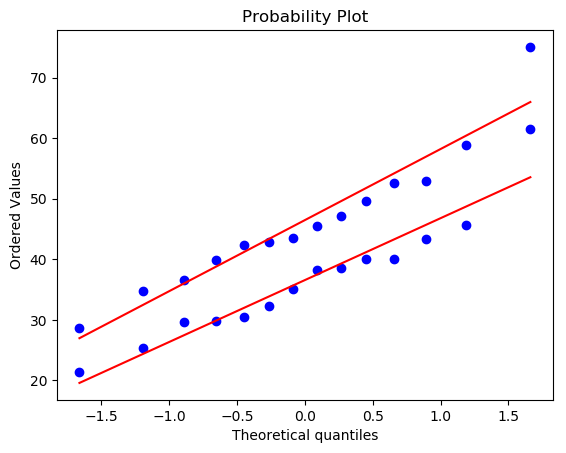

out [1.]


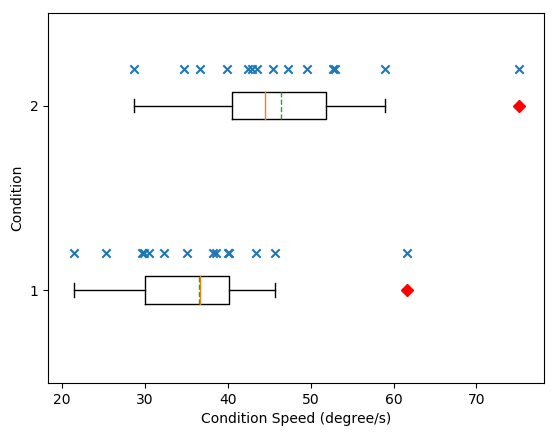

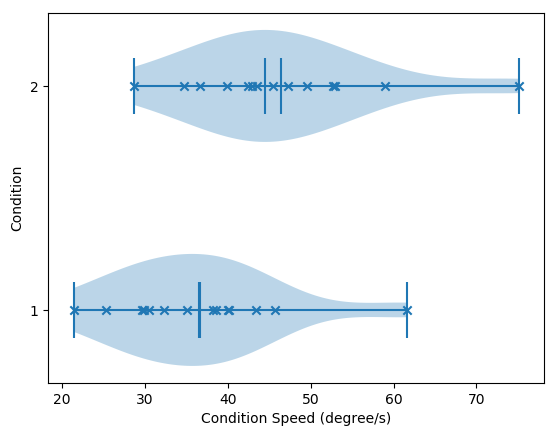

#####
First Sample
[174.2165999999997, 197.99440000000004, 253.0897999999994, 188.64223333333365, 215.19970000000006, 196.08643999999995, 165.36249999999978, 188.4030000000001, 247.88096, 122.73250000000013, 353.0782000000005, 298.0204666666667, 233.7408666666666, 254.47756666666695]
NormaltestResult(statistic=2.3300798496973547, pvalue=0.31191020881616405)
Second Sample
[166.33899999999994, 142.70009999999982, 189.61329999999964, 160.09660000000008, 173.49243333333322, 128.29133333333345, 178.32221999999996, 152.42250000000033, 206.42449999999977, 100.68782999999988, 143.6019, 263.2418000000001, 217.72697000000002, 176.31696666666673]
NormaltestResult(statistic=2.2179734491725656, pvalue=0.3298930643085266)
#####
T-Test of Two Samples
Ttest_relResult(statistic=3.5296395970393633, pvalue=0.003697868094168732)


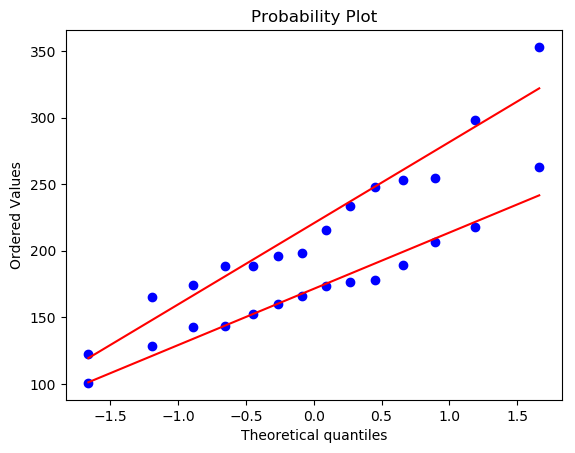

out [1.]


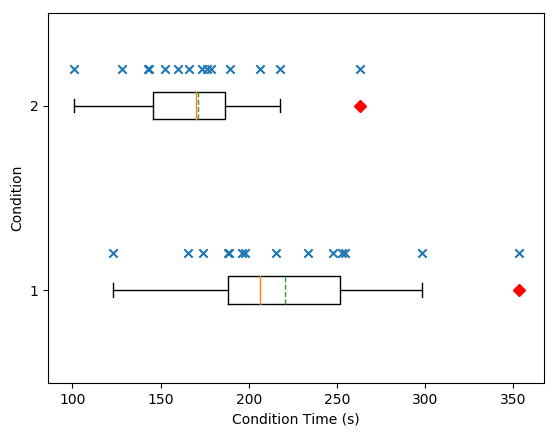

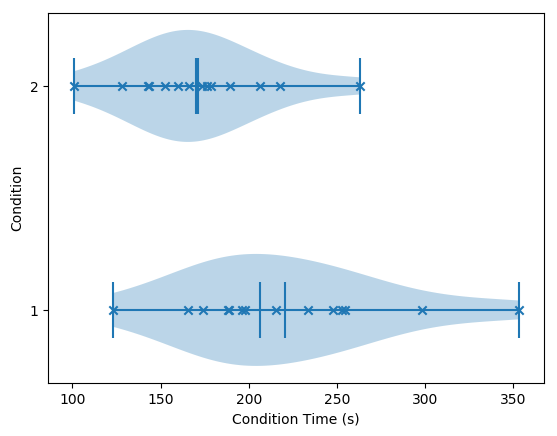

mean of 1st sample
220.63751666666667 882.5500666666667
mean of 2nd sample
171.37696095238093 685.5078438095237
ratio mean of two sample
1.3148290228671047
another way 0.7767353600670402
ratio^-1 mean of two sample
0.7991952509767001
another way 1.2874397786057914
#####
First Sample
[23.1681965  26.56746953 34.40992786 44.64524051 47.32089328 43.21981897
 34.11242152 32.49467466 40.43729986 56.84022047 59.04586412 56.31804923
 43.59719259 22.70066984 33.85032837 33.76052029 43.71911249 48.8991157
 40.61240887 32.42842569]
NormaltestResult(statistic=0.45558219759724955, pvalue=0.7962905885223037)
Second Sample
[26.65304404 32.37831311 34.42045038 48.8998627  56.89278161 60.12111003
 48.79421423 33.52220243 41.1311218  59.58909812 70.95313157 72.85399873
 68.18081101 27.50288478 35.85383919 36.2765477  50.62450242 58.41840161
 53.74114585 44.54926663]
NormaltestResult(statistic=2.198330023428255, pvalue=0.333149143225742)
#####
T-Test of Two Samples
Ttest_relResult(statistic=-5.473562498

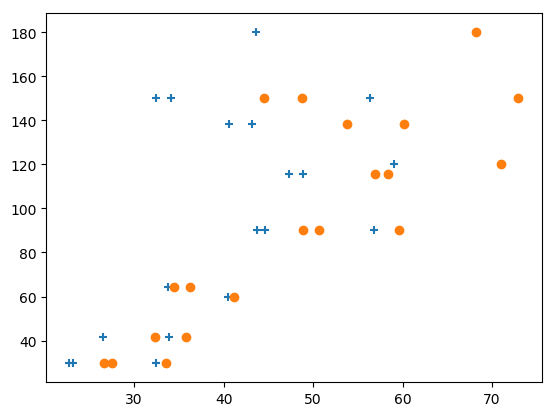

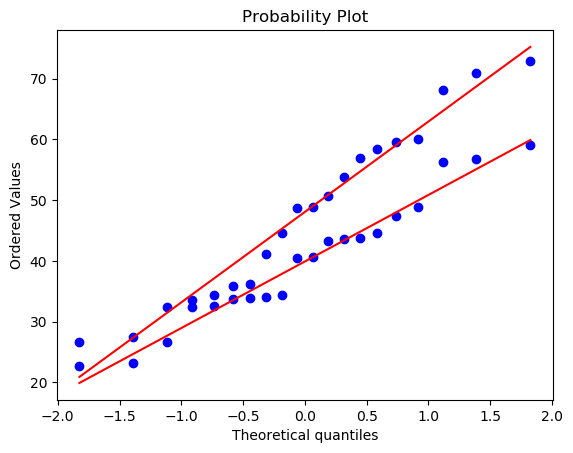

out []


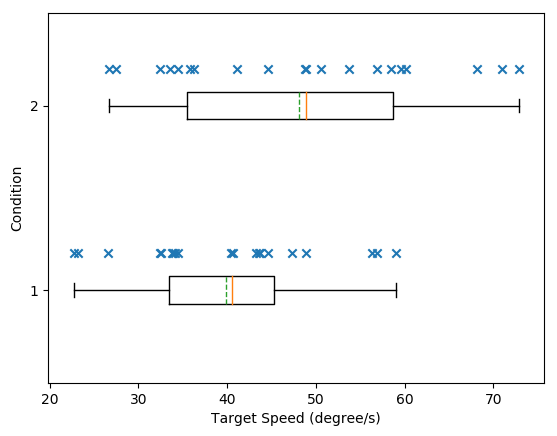

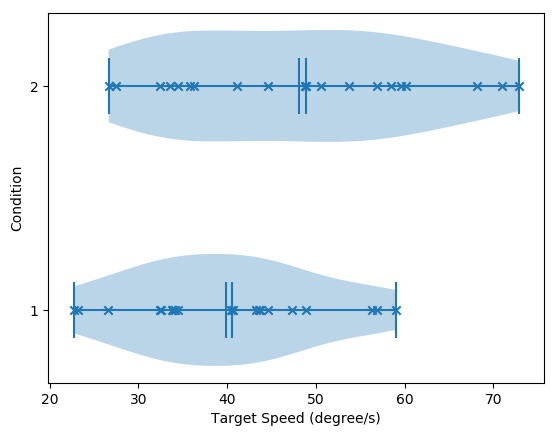

mean of 1st sample
39.90739251694718 159.62957006778873
mean of 2nd sample
48.067836396837926 192.2713455873517
ratio mean of two sample
0.8443816962545535
another way 1.204484516908122
ratio^-1 mean of two sample
1.2019842400306506
another way 0.830230680396766
#####
First Sample
[1.45975071 1.89842143 1.98508214 2.13251893 2.61326714 3.57389679
 5.48014143 1.01956821 1.54741429 1.70703821 2.21899643 3.17995714
 4.91231429 1.45521821 1.43338571 2.17874643 2.33334643 2.65550179
 3.70727179 5.07814964]
NormaltestResult(statistic=4.302761645414135, pvalue=0.11632342480083763)
Second Sample
[1.2485725  1.55013571 2.17014643 2.00039714 2.42582143 2.55669714
 3.51803393 0.98817643 1.57920357 1.61548571 1.88336714 2.21096857
 2.94199929 1.18615357 1.31544536 1.89462143 1.87443571 2.13213321
 2.74568214 3.69975964]
NormaltestResult(statistic=2.1805081980577397, pvalue=0.33613107227540345)
#####
T-Test of Two Samples
Ttest_relResult(statistic=3.934070366735682, pvalue=0.0008907245872804248)


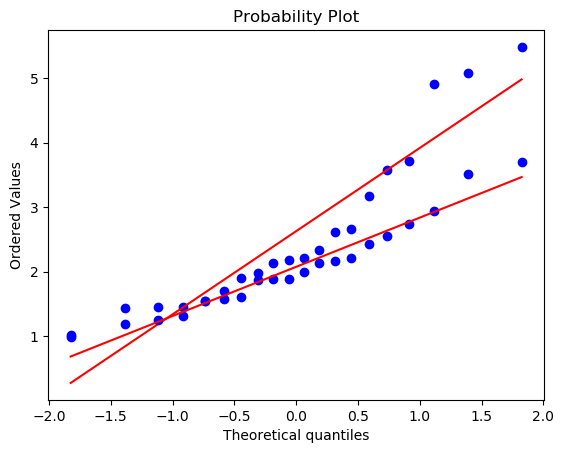

out []


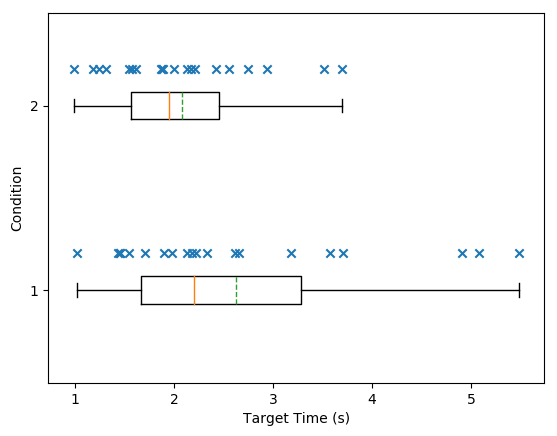

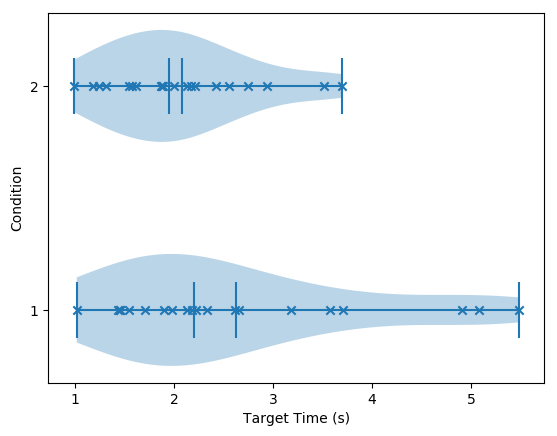

In [126]:
# from pylab import *

plt.style.use('default')

def anova_10x4(input_1, input_2):
    
    new_r_1 = np.array(input_1).T
    new_r_2 = np.array(input_2).T
    
    print("ANOVA of first sample")
    print(stats.f_oneway(new_r_1[0], new_r_1[1], new_r_1[2], new_r_1[3]))

    print("ANOVA of second sample")
    print(stats.f_oneway(new_r_2[0], new_r_2[1], new_r_2[2], new_r_2[3]))
    
    return
    

    

def anova_export(input_1, input2, name):
    with open(name, 'a') as csvFile:
        writer = csv.writer(csvFile)

        for i in range(len(input_1)):
            row = np.array(input_1[i]).flatten()
            writer.writerow(row)

        for i in range(len(input_2)):
            row = np.array(input_2[i]).flatten()
            writer.writerow(row)

        csvFile.close()

def plot_normal_test(input_1, input_2, y_title):

    print('#####')
    
    print('First Sample')
    print(input_1)
    print(stats.normaltest(input_1))
    
    print('Second Sample')
    print(input_2)
    print(stats.normaltest(input_2))
    
    print('#####')
    
    print("T-Test of Two Samples")
    print(ttest_rel(input_1, input_2))

    fig0, ax0 = plt.subplots()
    res = stats.probplot(input_1, dist='norm', plot=ax0)
    res = stats.probplot(input_2, dist='norm', plot=ax0)
    
    export_img("qqplot")
    plt.show()
    
    
    
    fig, ax = plt.subplots()

    r = ax.boxplot([input_1, input_2],  0, 'rD', 0, showmeans=True, meanline=True)
    out = r["fliers"][0].get_data()[1]
    print("out", out)
    
    ax.set_xlabel(y_title)
    ax.set_ylabel('Condition')
    ax.scatter([input_1, input_2],
                [[1.2 for i in input_1], [2.2 for i in input_2]],
                marker = "x", alpha=1)
    
    export_img('boxplot')
    plt.show()
    
    
    ## violin
    fig1, ax1 = plt.subplots()
    ax1.violinplot([input_1, input_2], vert=False,
               showmeans=True, showmedians=True, showextrema=True)

    ax1.set_xlabel(y_title)
    ax1.set_ylabel('Condition')
    ax1.scatter([input_1, input_2],
                [[1 for i in input_1], [2 for i in input_2]],
                marker = "x", alpha=1)
    plt.yticks([1,2], [1,2])
    
    export_img('violinplot')
    plt.show()
    

    
    
    
    
def cal_mean_of_ratio(input_1, input_2):
     
    ratio = []
    for i in range(len(input_1)):
        ratio.append(input_1[i] / input_2[i])
    ratio_mean = np.mean(ratio)
    print('mean of 1st sample')
    print(np.mean(input_1), 4*np.mean(input_1))
    print('mean of 2nd sample')
    print(np.mean(input_2), 4*np.mean(input_2))

    print('ratio mean of two sample')
    print(ratio_mean)
    print('another way', np.mean(input_2) / np.mean(input_1))

    ratio_0 = []
    for i in range(len(input_1)):
        ratio_0.append(input_2[i] / input_1[i])
    ratio_mean_0 = np.mean(ratio_0)

    print('ratio^-1 mean of two sample')
    print(ratio_mean_0)
    print('another way', np.mean(input_1) / np.mean(input_2))
    
    return
    
    
def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle

def distance_g():    
    distance=[]

    for lat in ['-30', '0', '30']:
        dis=[]
        for lon in ['0', '30', '60', '90', '120', '150', '180']:
            angle = angle_ac(int(lat), int(lon))
            dis.append(angle)
        distance.append(dis)
    
    distance = np.delete(np.array(distance).flatten(), 7)
    
    return distance   # 3*3*7 array{}

def plot_scatter(input_1, input_2):

    distance = distance_g()
    fig, ax = plt.subplots()
    #print(np.array(distance))
    #print(np.array(input_1))
    ax.scatter(np.array(input_1).flatten(), np.array(distance).flatten(), marker = "+")
    ax.scatter(np.array(input_2).flatten(), np.array(distance).flatten(), marker = "o")
    


    
anova_10x4(test1.round_10x4, test2.round_10x4)
#anova_export(test1.round_10x4, test2.round_10x4, 'ANOVA for C-R')

test1_condition = [np.sum(i) for i in test1.round_10x4]
test2_condition = [np.sum(i) for i in test2.round_10x4]

total = np.sum(distance_g()) * 4
average_speed_1 = total / test1_condition
average_speed_2 = total / test2_condition

print('##### condition 1 condition time')
print(np.mean(test1_condition))
print('##### condition 2 condition time')
print(np.mean(test2_condition))

print("##### total/average time ##### averge(total/time)")
print(total / np.mean(test1_condition), np.mean(average_speed_1))
print(total / np.mean(test2_condition), np.mean(average_speed_2))

plot_normal_test(average_speed_1, average_speed_2, 'Condition Speed (degree/s)')

#plot_scatter(test1_round_mean, test2_round_mean)
plot_normal_test(test1_condition, test2_condition, 'Condition Time (s)')
cal_mean_of_ratio(test1_condition, test2_condition)  

#anova_export(test1.speed_mean_3x7, test1.speed_mean_3x7, 'ANOVA for lat-lon')

#anova_export(test1.speed_mean_10x3x7, test2.speed_mean_10x3x7, 'ANOVA for C-T')

test1_speed_location = np.delete(np.array(test1.speed_mean_3x7).flatten(), 7)
test2_speed_location = np.delete(np.array(test2.speed_mean_3x7).flatten(), 7)

plot_scatter(test1_speed_location, test2_speed_location)
plot_normal_test(test1_speed_location, test2_speed_location, 'Target Speed (degree/s)')
cal_mean_of_ratio(test1_speed_location, test2_speed_location)


test1_time_location = np.delete(np.array(test1.time_mean_3x7).flatten(), 7)
test2_time_location = np.delete(np.array(test2.time_mean_3x7).flatten(), 7)

plot_normal_test(test1_time_location, test2_time_location, 'Target Time (s)')



t_all -3.1709367691553076 p_all 0.007368557164812926
[[-1.6845599731993237, -2.2991231979289384, -0.37167212111267844, -1.227691751737606, -1.6862020123055932, -3.103304734582438, -3.3861934517672503], [nan, -0.754001594637815, -0.22089596170568732, -0.909318625940824, -2.466145739480537, -3.78874637479429, -3.4791270869660242], [-2.413988411451575, -0.5225207752166141, -0.9784275257351909, -1.8234664456696175, -2.4589078589742943, -3.8527533276062087, -4.434007413482653]] [[0.11591496926087799, 0.03872177936485913, 0.7161245538182919, 0.2413292282264688, 0.11559271436748289, 0.008393206831107444, 0.004869822208791413], [nan, 0.4642873171188272, 0.8286049998289535, 0.37973203889159934, 0.028339480016741598, 0.002255038208498275, 0.004073920183908529], [0.03125534301559001, 0.6100973958826086, 0.3457206606870378, 0.0913001752121683, 0.02872790740311104, 0.001997079526389056, 0.0006741357984293228]]


/anaconda3/envs/leoncv/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


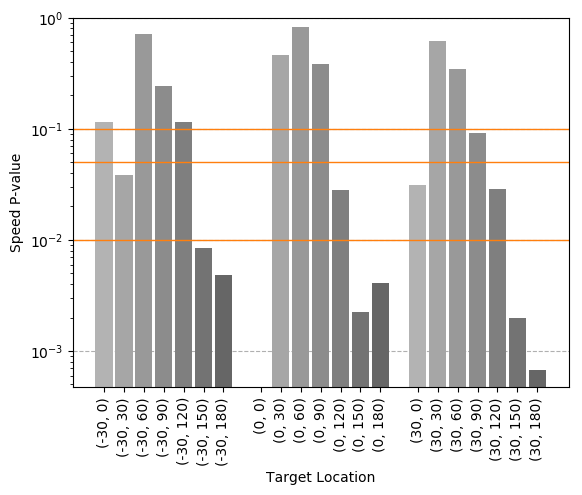

t_all 3.5056851118748047 p_all 0.0038716119005589517
[[1.351961875919059, 1.1180112150689197, -0.784226751611548, 0.6845290404468175, 0.6881942077800196, 3.3531684208862065, 2.964263834114887], [nan, 0.5413948607076288, -0.4530490326314363, 0.7158685206445689, 1.916914705364694, 3.0541572994298574, 3.0381235083020552], [2.2515237933160384, 0.4841111823592917, 1.363696803160425, 1.514106817012576, 1.6434880827150173, 3.6223383246553458, 4.435320594838873]] [[0.19944133124906682, 0.2837974538788812, 0.44696191318360823, 0.5056623963506537, 0.5034263854950867, 0.005188998570332938, 0.010967074428579474], [nan, 0.5973918625605157, 0.6579825376550785, 0.4867329641093787, 0.07749175575232894, 0.009225879736509039, 0.009514938887106071], [0.042288277852797644, 0.6363604742265132, 0.1958114925462289, 0.15392728746150014, 0.12423584773773783, 0.0030967345916257535, 0.0006725108850137869]]


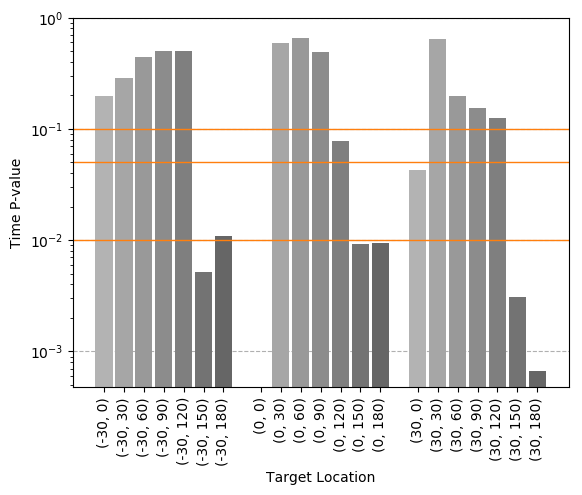

In [134]:
from matplotlib.ticker import NullFormatter
def plot_bar_single(mean, ymin=None, ymax=None, x_title=None, y_title=None, z_title=None):
    
    if (np.array(mean).shape == (3,7)):
        key1=[-30, 0, 30]
        key2=[0, 30, 60, 90, 120, 150, 180]
    else:
        key1=[0]
        key2=users[:]

    fig, ax = plt.subplots()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    if (len(key1) ==3):
        width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    else:
        width = 5
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean[k1][k2], 2*width, #label=str(key2[k2]
                    color= str(0.7-0.05*k2) )
                    #alpha=1-opacity*k2)
            
            x_axis.append(x)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))
    
    
    yref1=0.01
    yref2=0.05
    yref3=0.1
    plt.axhline(y=yref1,linewidth=1, color='C1')
    plt.axhline(y=yref2,linewidth=1, color='C1')
    plt.axhline(y=yref3,linewidth=1, color='C1')
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    plt.yscale('log')
    ax.set_axisbelow(True)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    if z_title is not None:
        ax.legend(title=z_title, loc=2)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.set_ylim(ymin, ymax)
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barsingle')
    plt.show()


def cal_ttest_3x7(t1, t2):
    tvalue=[]
    pvalue=[]
    for lat in range(3):
        tv=[]
        pv=[]
        for lon in range(7):
            all_user_t1=[]
            all_user_t2=[]
            for user in range(len(t1)):
                all_user_t1.append(t1[user][lat][lon])
                all_user_t2.append(t2[user][lat][lon])

            t,p = ttest_rel(all_user_t1, all_user_t2)
            tv.append(t) # *7
            pv.append(p)
        tvalue.append(tv)
        pvalue.append(pv)# *3
    
    d1 =[]
    d2 =[]
    for user in range(len(t1)):
        data_1 = [i for i in np.array(t1[user]).flat if (i!=0)]
        data_2 = [i for i in np.array(t2[user]).flat if (i!=0)]
        d1.append(np.mean(data_1))
        d2.append(np.mean(data_2))
        
    t_all,p_all = ttest_rel(d1, d2)
    print('t_all', t_all, 'p_all', p_all)
    
    return tvalue, pvalue
    
speed_t, speed_p = cal_ttest_3x7(test1.speed_mean_10x3x7, test2.speed_mean_10x3x7)
print(speed_t, speed_p)
plot_bar_single(speed_p, 0, 1,'Target Location', 'Speed P-value')


time_t, time_p = cal_ttest_3x7(test1.time_mean_10x3x7, test2.time_mean_10x3x7)
print(time_t, time_p)
plot_bar_single(time_p, 0, 1,'Target Location', 'Time P-value')


#plot_bar_single(time_t)

[]
[]
[]
[]


<Figure size 1200x1600 with 0 Axes>

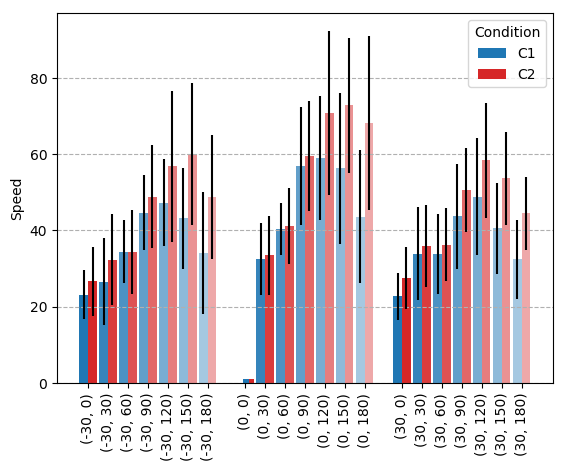

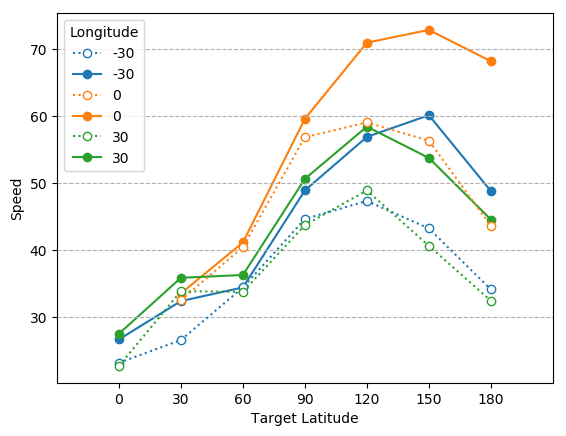

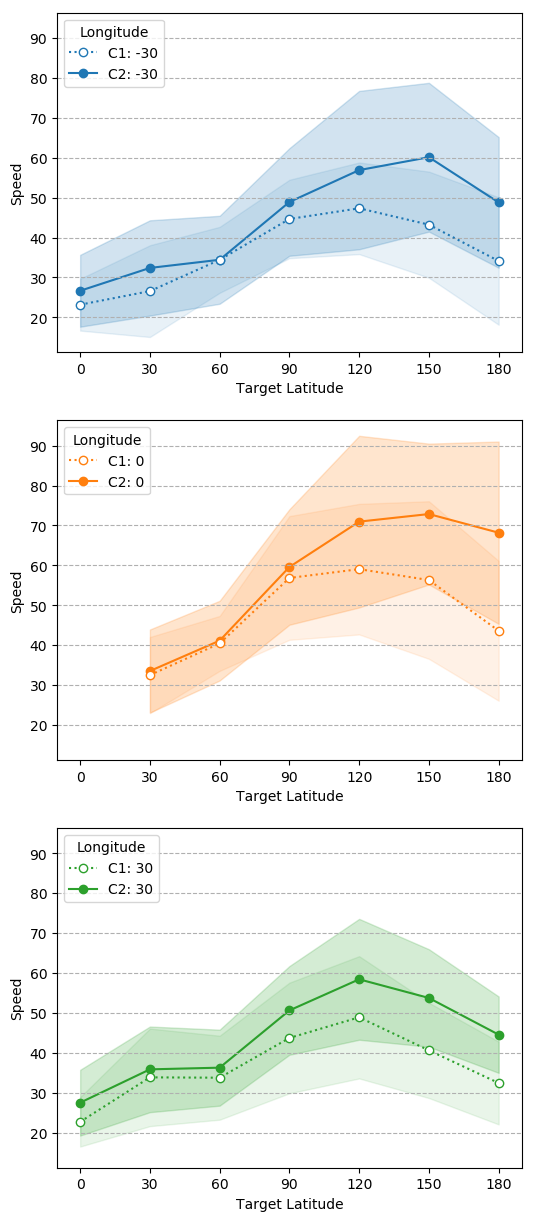

(3, 7)
#####
ratio [[1.15041514 1.21872025 1.0003058  1.09529845 1.20227615 1.39105418
  1.43039433]
 [1.         1.03162142 1.01715797 1.04836149 1.20166133 1.29361723
  1.56388077]
 [1.21154508 1.05918734 1.07452573 1.157949   1.19467194 1.3232691
  1.37377211]]
log [[2.02154568e-01 2.85367002e-01 4.41107084e-04 1.31324032e-01
  2.65768311e-01 4.76178617e-01 5.16412920e-01]
 [0.00000000e+00 4.49136346e-02 2.45437534e-02 6.81362620e-02
  2.65030351e-01 3.71410797e-01 6.45130524e-01]
 [2.76848082e-01 8.29577806e-02 1.03700029e-01 2.11571709e-01
  2.56614510e-01 4.04106481e-01 4.58142696e-01]]
#####
RATIO!!
remove one


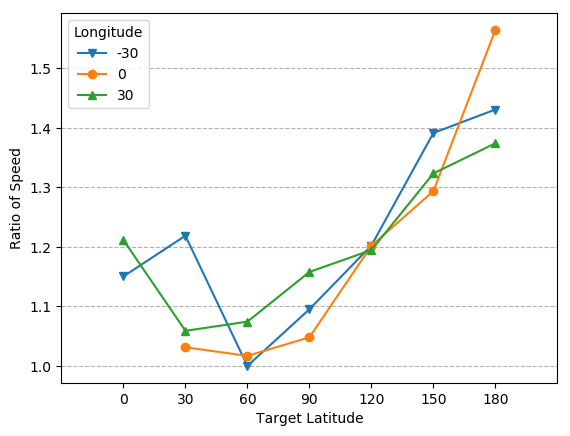

LOG!!
remove zero


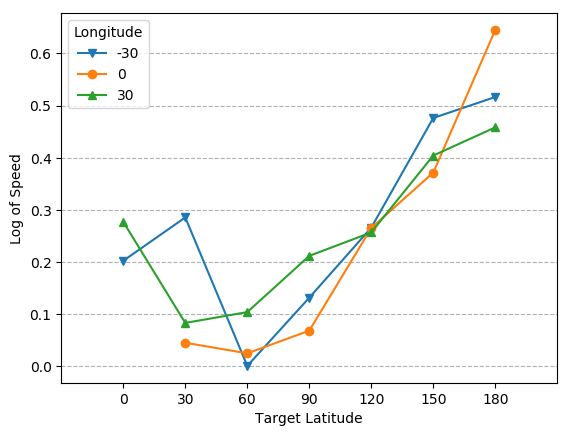

<Figure size 1200x1600 with 0 Axes>

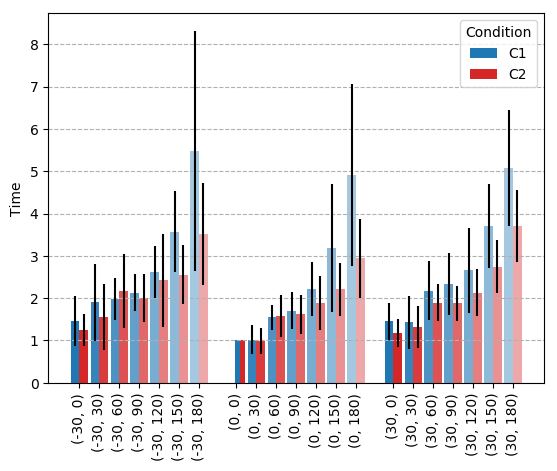

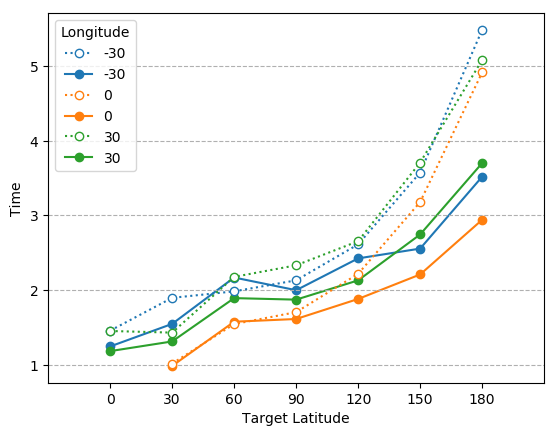

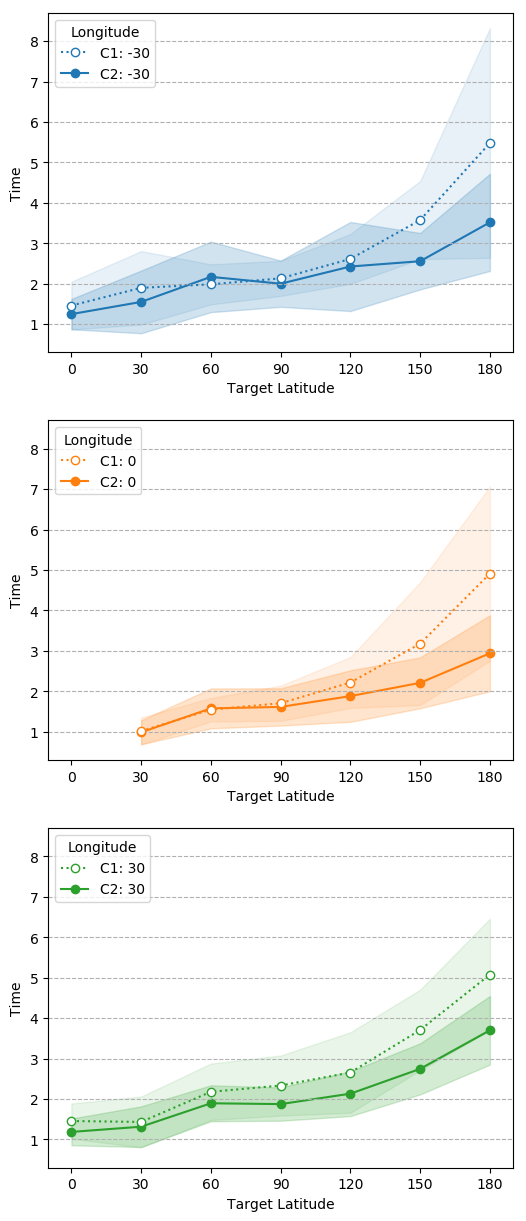

(3, 7)
#####
ratio [[0.85533269 0.81653931 1.09322752 0.93804426 0.92827151 0.7153808
  0.64196043]
 [1.         0.96921071 1.02054349 0.94636763 0.84874726 0.69528251
  0.5989029 ]
 [0.81510358 0.91771904 0.86959244 0.80332508 0.80291161 0.74062068
  0.72856452]]
log [[-0.22544242 -0.29240576  0.12859368 -0.0922721  -0.10738126 -0.4832167
  -0.63944373]
 [ 0.         -0.04511775  0.02933766 -0.07952736 -0.23659308 -0.5243288
  -0.73960597]
 [-0.2949447  -0.12387556 -0.20158869 -0.31594417 -0.31668692 -0.43319327
  -0.45687136]]
#####
RATIO!!
remove one


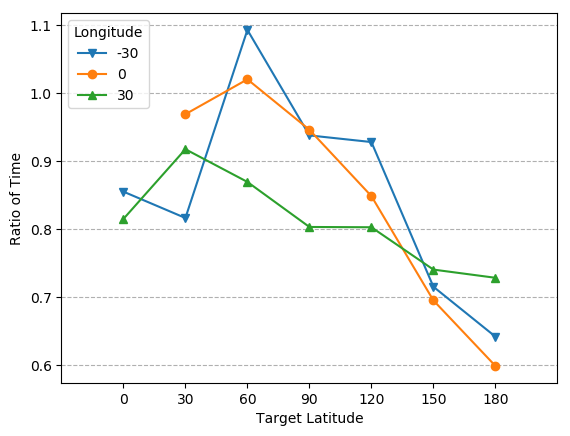

LOG!!
remove zero


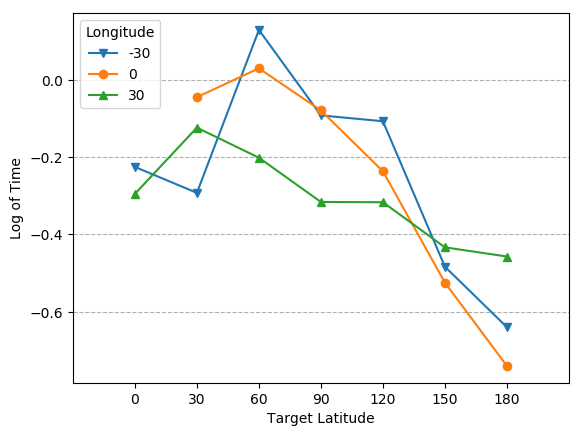

In [135]:
def plot_bar_dual_any(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None):
    
    key1, key2 = which_axis(input_mean_1)
    
    mean_1 = input_mean_1
    mean_2 = input_mean_2
    
    std_1 = input_std_1 if (input_std_1 is not None) else np.zeros_like[mean_1]
    std_2 = input_std_2 if (input_std_2 is not None) else np.zeros_like[mean_2]


    plt.figure(1, figsize = (12,16))  
    fig, ax = plt.subplots()
    
    #plt.subplot(2, 1, 1)
    #ax = plt.gca()
    
    #x = np.arange(3)
    #width = 0.05
    #gap = 0.02
    opacity = 0.1
    
    width = np.abs(key1[0] - key1[1]) / ( len(key2) + 2) / 2
    gap = width / len(key2)
    offset = (width)
    
    x_axis = []
    x_label = []
    
    for k1 in range(len(key1)):
        for k2 in range(len(key2)):
            x = key1[k1] + (width)*2*k2 + (gap)*2*k2
            
            plt.bar(x , mean_1[k1][k2], width, #label=str(key2[k2]
                    color="C0", alpha=1-opacity*k2, yerr=std_1[k1][k2])
            plt.bar(x + offset , mean_2[k1][k2], width,
                    color="C3", alpha=1-opacity*k2, yerr=std_2[k1][k2])
            
            x_axis.append(x+0.5*offset)
            #x_label.append('('+str(key1[k1])+','+str(key2[k2])+')')
            x_label.append((key1[k1],key2[k2]))
    
    plt.bar(1,1,1, color="C0", label="C1")
    plt.bar(2,1,1, color="C3", label="C2")
        
    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.set_ylabel(y_title)
    #ax.set_ylabel(kind)
    #plt.ylim(0,ymax)
    ax.legend(title="Condition")
    
    plt.xticks(x_axis, x_label, rotation=90)
    
    export_img('barplot')
    plt.show()
    

    

def plot_line_dual_any(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None): 
    
    key1, key2 = which_axis(input_mean_1)
    
    std_1 = input_std_1 if (input_std_1 is not None) else np.zeros_like[input_mean_1]
    std_2 = input_std_2 if (input_std_2 is not None) else np.zeros_like[input_mean_2]
    
    mean_1 = input_mean_1
    mean_2 = input_mean_2
    
    fig0, ax0 = plt.subplots()


    #if (np.array(mean_1).shape == (7,3)):
    
    m_style = dict(markerfacecolor='white', markeredgewidth =2)
    
    for k1 in range(len(key1)):
        if (0 in mean_1[k1]):
            data_1= list(mean_1[k1])[:]
            data_2= list(mean_2[k1])[:]
            data_1.remove(0.)
            data_2.remove(0.)
            kkey = key2[:]
            kkey.remove(0)

            plt.plot(kkey, data_1, ':o', color = 'C'+ str(k1), 
                     markerfacecolor='white', markeredgewidth =1, zorder=5,
                     label=str(key1[k1]))
            plt.plot(kkey, data_2, '-o', color = 'C'+ str(k1), zorder=0,
                     label=str(key1[k1]))
        else:
            plt.plot(key2, mean_1[k1], ':o', color = 'C'+ str(k1),
                     markerfacecolor='white', markeredgewidth =1, zorder=5,
                     label=str(key1[k1]))
            plt.plot(key2, mean_2[k1], '-o', color = 'C'+ str(k1), zorder=0,
                     label=str(key1[k1]))
        
        
        
    ax0 = plt.gca()
    ax0.yaxis.grid(True, linestyle = "--")
    ax0.legend(title="Longitude", loc=2)
    ax0.set_ylabel(y_title)
    ax0.set_xlabel('Target Latitude')
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    

    
    
    if (1<5):
        fig, axs = plt.subplots(3,1,sharey=True, figsize=(6,15))
        for k1 in range(len(key1)):
            #fig, ax =plt.subplots(sharey=True)
            
            errmax_1 = np.array(remove_zero(mean_1[k1])) + np.array(remove_zero(std_1[k1]))
            errmin_1 = np.array(remove_zero(mean_1[k1])) - np.array(remove_zero(std_1[k1]))   
            errmax_2 = np.array(remove_zero(mean_2[k1])) + np.array(remove_zero(std_2[k1]))
            errmin_2 = np.array(remove_zero(mean_2[k1])) - np.array(remove_zero(std_2[k1]))
                         
            key_temp = remove_zero(key2) if (0 in mean_1[k1]) else key2

            axs[k1].plot(key_temp, remove_zero(mean_1[k1]),':o', zorder=5,
                         color = 'C'+ str(k1),
                     markerfacecolor='white', markeredgewidth =1,
                     label='C1: '+str(key1[k1]))
            axs[k1].fill_between(key_temp, errmin_1, errmax_1,
                             alpha=0.1, color = 'C'+ str(k1), edgecolor='')

            axs[k1].plot(key_temp, remove_zero(mean_2[k1]), '-o', zorder=0,
                         color = 'C'+ str(k1), label='C2: '+str(key1[k1]))
            axs[k1].fill_between(key_temp, errmin_2, errmax_2,
                             alpha=0.2, color = 'C'+ str(k1), edgecolor='')

            #axs = plt.gca()
            axs[k1].yaxis.grid(True, linestyle = "--")
            axs[k1].legend(title="Longitude", loc=2)
            axs[k1].set_xlabel('Target Latitude')
            axs[k1].set_ylabel(y_title)
            axs[k1].set_xticks(key2)
            
            axs[k1].set_xlim(key2[0]-10, key2[-1]+10)
            #ax.set_ylim(0, 6)
    
    
    
            
    if (6<5):
        for k1 in range(len(key1)):
            fig,ax=plt.subplots()
            if (1 in ratio_c[k1]):
                data_1= list(ratio_c[k1])[:]
                data_1.remove(1.)
                kkey = key2[:]
                kkey.remove(0)

                plt.plot(kkey, data_1, '-o', color = 'C'+ str(k1), label=str(key1[k1]))
            else:
                plt.plot(key2, ratio_c[k1], '-o', color = 'C'+ str(k1), label=str(key1[k1]))

            ax = plt.gca()
            ax.yaxis.grid(True, linestyle = "--")
            ax.legend(title="Longitude", loc=2)
            ax.set_xlabel('Target Latitude')
            ax.set_ylabel('Time')
            plt.xticks(key2, key2)
            plt.xlim(key2[0]-30, key2[-1]+30)
            ax.set_ylim(bottom=0, top=2)
    
    export_img('trio')
    plt.show()
    
def plot_line_simple_3x7(input_data, yy_title, data_type=None):
    
    key1, key2 = which_axis(input_data)

    if (data_type == 'ratio'):
        data_to_delete = 1.
        print('RATIO!!')
    elif (data_type == 'log'):
        data_to_delete = 0
        print('LOG!!')
    else:
        data_to_delete = 100

    fig,ax = plt.subplots()
    
    marks=['v', 'o', '^']

    for k1 in range(len(key1)):

        if (data_to_delete in input_data[k1]):
            key_temp = remove_zero(key2)
            if (data_type == 'ratio'):
                new_data = remove_one(input_data[k1])
                print('remove one')
            elif (data_type == 'log'):
                new_data = remove_zero(input_data[k1])
                print('remove zero')
        else:
            key_temp = key2
            new_data = input_data[k1][:]

        plt.plot(key_temp, new_data, '-'+marks[k1], color = 'C'+ str(k1), label=str(key1[k1]))


    ax = plt.gca()
    ax.yaxis.grid(True, linestyle = "--")
    ax.legend(title="Longitude", loc=2)
    ax.set_xlabel('Target Latitude')
    ax.set_ylabel(yy_title)
    plt.xticks(key2, key2)
    plt.xlim(key2[0]-30, key2[-1]+30)
    #ax.set_ylim(0.4, 1.2)
    export_img('line')
    plt.show()
    
    

def plot_ratio(y_title, input_mean_1, input_mean_2):
    print(np.array(input_mean_1).shape)
    ratio, log = User.cal_ratio(input_mean_1, input_mean_2)
    ##########
    print('#####')
    print('ratio', np.array(ratio))
    print('log', np.array(log))
    print('#####')
    #########  
    
    plot_line_simple_3x7(ratio, 'Ratio of '+ y_title, 'ratio')
    plot_line_simple_3x7(log, 'Log of '+ y_title, 'log')
    
    
    
def plot_line_dual_any_plus(y_title, input_mean_1, input_mean_2, input_std_1=None, input_std_2=None):
    plot_line_dual_any(y_title, input_mean_1, input_mean_2, input_std_1, input_std_2)
    plot_ratio(y_title, input_mean_1, input_mean_2)
    
    
    
#############

print(test1.time_mean_lat)
print(test2.time_mean_lat)
print(test1.time_mean_lon)
print(test2.time_mean_lon)

#print(Exp.cal_mean_3_old(test1.time_mean_3x7))
#print(Exp.cal_mean_3(test1.time_mean_10x3x7))
#print(Exp.cal_mean_3(test2.time_mean_10x3x7))

#print(Exp.cal_mean_7_old(test1.time_mean_3x7))
#print(Exp.cal_mean_7(test1.time_mean_10x3x7))
#print(Exp.cal_mean_7(test2.time_mean_10x3x7))

#print(np.array(test1.time_mean_3x7))
#print(np.array(test2.time_mean_3x7))

if (False):
    print('test1')
    print(test1.speed_mean_3x7)
    print(test1.speed_std_3x7)

    print('test2')
    print(test2.speed_mean_3x7)
    print(test2.speed_std_3x7)

plot_bar_dual_any('Speed', test1.speed_mean_3x7, test2.speed_mean_3x7,
                  test1.speed_std_3x7, test2.speed_std_3x7)
plot_line_dual_any_plus('Speed', test1.speed_mean_3x7, test2.speed_mean_3x7,
                   test1.speed_std_3x7, test2.speed_std_3x7)

plot_bar_dual_any('Time', test1.time_mean_3x7, test2.time_mean_3x7,
                  test1.time_std_3x7, test2.time_std_3x7)
plot_line_dual_any_plus('Time', test1.time_mean_3x7, test2.time_mean_3x7,
                   test1.time_std_3x7, test2.time_std_3x7)


#plot_bar(np.array(test1.speed_mean_3x7).T, np.array(test2.speed_mean_3x7).T,
#         np.array(test1.speed_std_3x7).T, np.array(test2.speed_std_3x7).T)


[[1.45975071 1.89842143 1.98508214 2.13251893 2.61326714 3.57389679
  5.48014143]
 [0.         1.01956821 1.54741429 1.70703821 2.21899643 3.17995714
  4.91231429]
 [1.45521821 1.43338571 2.17874643 2.33334643 2.65550179 3.70727179
  5.07814964]]
[1.45975071 1.89842143 1.98508214 2.13251893 2.61326714 3.57389679
 5.48014143 1.01956821 1.54741429 1.70703821 2.21899643 3.17995714
 4.91231429 1.45521821 1.43338571 2.17874643 2.33334643 2.65550179
 3.70727179 5.07814964]
2.6284993571428577 2.0768618035714277


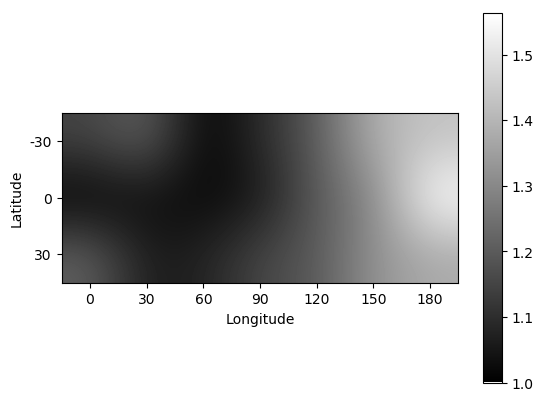

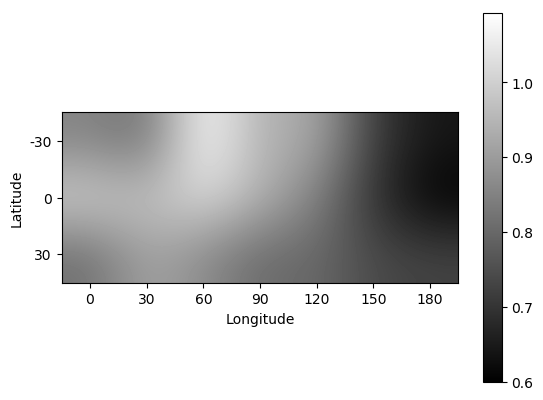

In [136]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_heatmap_3x7(input_data):

    fig, ax = plt.subplots()
    
    y = LAT_KEY_F
    x = LON_KEY_F
    z = np.array(input_data)
    im = ax.imshow(z, cmap=cm.gray, interpolation='bicubic')
    #divider = make_axes_locatable(ax)
    #cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, ax=ax)
    
    plt.xticks(range(len(x)),x)
    plt.yticks(range(len(y)),y)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    export_img('heatmap')
    plt.show()

#print(np.array(test1.time_mean_group))
print(np.array(test1.time_mean_3x7))
print(np.delete(np.array(test1.time_mean_3x7), 7))
print(test1.time_mean_overall, test2.time_mean_overall)


ratio_speed, log_speed= User.cal_ratio(test1.speed_mean_3x7, test2.speed_mean_3x7)
ratio_time, log_time= User.cal_ratio(test1.time_mean_3x7, test2.time_mean_3x7)
plot_heatmap_3x7(ratio_speed)
plot_heatmap_3x7(ratio_time)

(14, 3, 7)
(14, 20)
t_all -3.1709367691553076 p_all 0.007368557164812926
T-statistics
[-1.1184283031275704, -5.774715504908127, -4.632682120590158, -3.4299759906784075, -3.999150311361813, -3.9270048306865695, 5.244990296892097, -3.8190131002956225, -3.4231138927977285, -4.803405162985103, -10.909945929780411, -0.11755889503578533, 1.5075598632560896, -2.6212552252942243]
P-value
[0.2773259815647313, 1.4530898000065284e-05, 0.00018153247546477664, 0.002807410237764415, 0.000767680894210988, 0.0009052167102082849, 4.6132210354517264e-05, 0.001158391457176255, 0.0028513659884234674, 0.0001235166920094767, 1.2713561572678604e-09, 0.9076510303472878, 0.14811491425303197, 0.016804540006993104]
1
2
3
4
5
6
7
8
9
10
13


/anaconda3/envs/leoncv/lib/python3.7/site-packages/ipykernel_launcher.py:57: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


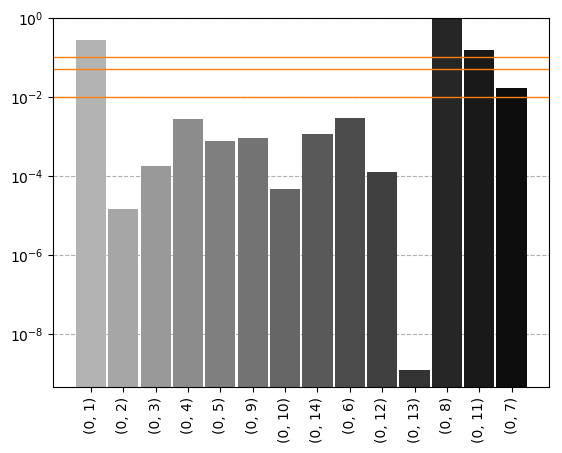

In [146]:
def cal_ttest_20(t1, t2):
    tvalue=[]
    pvalue=[]
    for user in range(len(t1)):
        tv,pv = ttest_rel(t1[user], t2[user])
        tvalue.append(tv)
        pvalue.append(pv)# *30
    
    d1 =[]
    d2 =[]
    for user in range(len(t1)):
        data_1 = [i for i in np.array(t1[user]).flat if (i!=0)]
        data_2 = [i for i in np.array(t2[user]).flat if (i!=0)]
        d1.append(np.mean(data_1))
        d2.append(np.mean(data_2))
        
    t_all,p_all = ttest_rel(d1, d2)
    print('t_all', t_all, 'p_all', p_all)
    
    return tvalue, pvalue



t1_speed_10x3x7=test1.speed_mean_10x3x7
t2_speed_10x3x7=test2.speed_mean_10x3x7
print(np.array(t1_speed).shape)
t1_speed_10=[np.delete(np.array(i).flatten(), 7) for i in t1_speed_10x3x7]
t1_ss=[ [j for j in np.array(t1_speed_10x3x7[1]).flatten() if (j!=0)] for i in t1_speed_10x3x7]
t2_speed_10=[np.delete(np.array(i).flatten(), 7) for i in t2_speed_10x3x7]
print(np.array(t1_ss).shape)
user_t, user_p = cal_ttest_20(t1_speed_10, t2_speed_10)
print('T-statistics')
print(user_t)
print('P-value')
print(user_p)
for i in range(len(ps)):
    if (user_p[i]<0.05): print(i)
        
plot_bar_single([user_p], 0, 1, x_title=None, y_title=None, z_title=None)

In [221]:
# print(np.sum(test1.time_mean_10x3x7[5]))
print(np.median(test1.round_10x4[5]))

def cal_lat_lon(input_data):
    lat_time=[]
    lon_time=[]
     
            
    for user in range(len(input_data)):
        u_lat=[]
        u_lon=[]
        for lat in range(3):
            u_lat.append(np.sum(input_data[user][lat]))
            
        for lon in range(7):
            u_lon.append(np.sum(np.array(input_data[user]).T[lon]))
        
        lat_time.append(u_lat)
        lon_time.append(u_lon)
        
        #lon_t=[]
        #for lon in range(7):
        #    for lat in range(3):
        #        lat_time.append(np.sum(input_data[user][lat]))
        #        lon_t.append(input_data[user][lat][lon])
        #    lon_time.append(np.sum(lon_t))
        
    return lat_time, lon_time

test1_lat_time, test1_lon_time = cal_lat_lon(test1.time_mean_10x3x7)
test2_lat_time, test2_lon_time = cal_lat_lon(test2.time_mean_10x3x7)

stats.ttest_rel(np.array(test1_lon_time).T[0], np.array(test2_lon_time).T[0])

48.62741999999997


Ttest_relResult(statistic=2.0076843488081484, pvalue=0.06592641863929245)

In [180]:
from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)

#x = np.concatenate((a, b))

#x = test2_round_mean
# x = 1 / np.array(test2_round_mean) almost not
#x = test2_speed_location
#x = 1 / np.array(test1_speed_location) almost not

#test1_round_mean, test2_round_mean



x = np.array(test2_round_mean)
x=np.array(a)+np.array(b)


#x = [i for i in np.array(test2.speed_mean_10x3x7[0]).flatten() if (i!=0)]

tar = test1.speed_mean_10x3x7
for lat in range(3):
    for lon in range(7):
        print(LAT_KEY[lat],LON_KEY[lon])
        x = [tar[i][lat][lon] for i in range(len(tar))]
        #print(x)
        #print(stats.normaltest(x))
        k2, p = stats.normaltest(x)

        alpha = 1e-3
        print("p = {:g}".format(p))

        if p < alpha:  # null hypothesis: x comes from a normal distribution
            print("The null hypothesis can be rejected\n NO")
        else:
            print("The null hypothesis cannot be rejected\n YES")
    
    


-30 0
p = 0.853211
The null hypothesis cannot be rejected
 YES
-30 30
p = 0.000832311
The null hypothesis can be rejected
 NO
-30 60
p = 0.0562275
The null hypothesis cannot be rejected
 YES
-30 90
p = 0.40406
The null hypothesis cannot be rejected
 YES
-30 120
p = 0.107336
The null hypothesis cannot be rejected
 YES
-30 150
p = 0.00149738
The null hypothesis cannot be rejected
 YES
-30 180
p = 0.00113231
The null hypothesis cannot be rejected
 YES
0 0
p = 8.80282e-141
The null hypothesis can be rejected
 NO
0 30
p = 0.901389
The null hypothesis cannot be rejected
 YES
0 60
p = 0.801546
The null hypothesis cannot be rejected
 YES
0 90
p = 0.592264
The null hypothesis cannot be rejected
 YES
0 120
p = 0.277711
The null hypothesis cannot be rejected
 YES
0 150
p = 0.992807
The null hypothesis cannot be rejected
 YES
0 180
p = 0.00422836
The null hypothesis cannot be rejected
 YES
30 0
p = 0.86094
The null hypothesis cannot be rejected
 YES
30 30
p = 0.586083
The null hypothesis cannot be

In [139]:
def anova_10x4(input_1, input_2):
    
    new_r_1 = np.array(input_1).T
    new_r_2 = np.array(input_2).T
    
    print("ANOVA of first sample")
    print(stats.f_oneway(new_r_1[0], new_r_1[1], new_r_1[2], new_r_1[3]))

    print("ANOVA of second sample")
    print(stats.f_oneway(new_r_2[0], new_r_2[1], new_r_2[2], new_r_2[3]))
    
    return



NormaltestResult(statistic=0.45558219759724955, pvalue=0.7962905885223037)
NormaltestResult(statistic=2.198330023428255, pvalue=0.333149143225742)
##ttest_rel(new_r_1_mean, new_r_2_mean)
Ttest_relResult(statistic=-5.4735624987066895, pvalue=2.791610285571956e-05)
new_r_mean_ratio_mean 1.2019842400306506
another way 1.204484516908122
new_r_mean_1/ratio_mean 0.8443816962545535


NameError: name 'out' is not defined

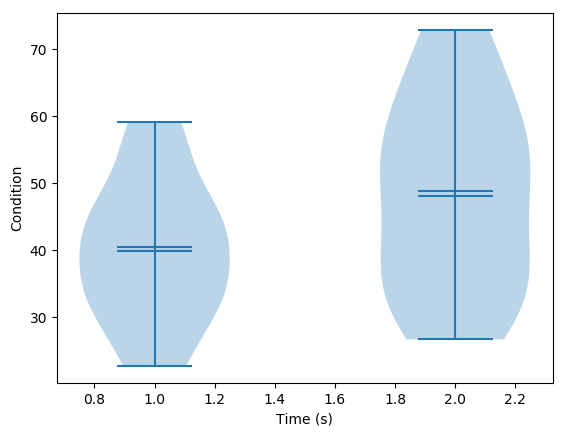

In [140]:
new_r_1 = np.array(test1.round_10x4).T
new_r_2 = np.array(test2.round_10x4).T

new_r_1_mean = np.delete(np.array(test1.speed_mean_3x7).flatten(), 7)
new_r_2_mean = np.delete(np.array(test2.speed_mean_3x7).flatten(), 7)

print(stats.normaltest(new_r_1_mean))
print(stats.normaltest(new_r_2_mean))

print("##ttest_rel(new_r_1_mean, new_r_2_mean)")
print(ttest_rel(new_r_1_mean, new_r_2_mean))


new_r_mean_ratio = []
for i in range(len(new_r_1_mean)):
    new_r_mean_ratio.append(new_r_2_mean[i] / new_r_1_mean[i])
new_r_mean_ratio_mean = np.mean(new_r_mean_ratio)

print('new_r_mean_ratio_mean', new_r_mean_ratio_mean)
print('another way', np.mean(new_r_2_mean) / np.mean(new_r_1_mean))

new_r_mean_ratio = []
for i in range(len(new_r_1_mean)):
    new_r_mean_ratio.append(new_r_1_mean[i] / new_r_2_mean[i])
new_r_mean_ratio_mean = np.mean(new_r_mean_ratio)

print('new_r_mean_1/ratio_mean', new_r_mean_ratio_mean)
    
from pylab import *
fig, ax = plt.subplots()

#r = ax.boxplot([new_r_1_mean, new_r_2_mean],  0, 'rD', 0, showmeans=True)
ax.violinplot([new_r_1_mean, new_r_2_mean],
               showmeans=True, showmedians=True, showextrema=True)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Condition')
#ax.scatter([new_r_1_mean, new_r_2_mean],
#            [[1.2 for i in new_r_1_mean], [2.2 for i in new_r_2_mean]],
 #           marker = "x")

#out = r["fliers"][0].get_data()[1]
print("out", out)

#print(new_r_1.shape)
print(new_r_1_mean)
print(new_r_2_mean)



def distance():
        
    distance=[]

    for lat in ['-30', '0', '30']:
        dis=[]
        for lon in ['0', '30', '60', '90', '120', '150', '180']:
            angle = angle_ac(int(lat), int(lon))
            dis.append(angle)
        distance.append(dis)

    return distance   # 3*3*7 array{}



def angle_ac(lat, lon):
    angle = math.degrees( math.acos( math.cos(math.radians(lat)) * math.cos(math.radians(lon)) ) )
    return angle
    
    

distance = distance()
fig2, ax2 = plt.subplots()
print(np.array(distance))
print(np.array(test1.time_mean_3x7))
ax2.scatter( np.array(distance).flatten(),
             np.array(test1.speed_mean_3x7).flatten(), marker = "+")
ax2.scatter( np.array(distance).flatten(),
             np.array(test2.speed_mean_3x7).flatten(), marker = "o")
plt.show()


49.02160999999999
48.62741999999997


In [ ]:
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)
pts =1000
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)
x = np.concatenate((a, b))

# Load the example tips dataset
#tips = sns.load_dataset("tips")
tips = {'C1':list(np.array(test1.time_mean_3x7).flatten()),
                'C2':list(np.array(test2.time_mean_3x7).flatten())}
tips=b
#print(tips)


# Draw a nested violinplot and split the violins for easier comparison
sns.violinplot(x=tips, #hue="C1",
               split=True, inner="quart",
               #palette={0: "y", 1: "b"},
               #data = tips,
               orient = 'v')
              
#sns.despine(left=True)

from scipy import stats
pts = 1000
np.random.seed(28041990)
a = np.random.normal(0, 1, size=pts)
b = np.random.normal(2, 1, size=pts)

#x = np.concatenate((a, b))

x = b

#x = test2_round_mean
# x = 1 / np.array(test2_round_mean) almost not
#x = test2_speed_location
#x = 1 / np.array(test1_speed_location) almost not

k2, p = stats.normaltest(x)

alpha = 1e-3
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected\n NO")
else:
    print("The null hypothesis cannot be rejected\n YES")


In [ ]:
X = [-30,0,30]
Y = [0,30,60,90,120,150,180]
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)
print(Z)
print(type(Z))
print(Z[0][0].shape ==())

In [ ]:
print(np.arange(-5, 5, 0.25))

In [ ]:
_x = np.arange(4)
_y = np.arange(5)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

top = x + y
bottom = np.zeros_like(top)
print(x)
print(y)
print(top)
print(bottom)
listx = list(x)
listx.sort()
print(listx)
print(listx[1:-1])
print(np.median([5,1,2,5]))


In [ ]:
A = np.random.rand(5, 5)

print(np.delete(A,6))
print(A)

In [ ]:

## Define 2 random distributions
#Sample Size
N = 10
#Gaussian distributed data with mean = 2 and var = 1
a = np.random.randn(N) + 2
#Gaussian distributed data with with mean = 0 and var = 1
b = np.random.randn(N)


## Calculate the Standard Deviation
#Calculate the variance to get the standard deviation

#For unbiased max likelihood estimate we have to divide the var by N-1, and therefore the parameter ddof = 1
var_a = a.var(ddof=1)
var_b = b.var(ddof=1)

#std deviation
s = np.sqrt((var_a + var_b)/2)
s



## Calculate the t-statistics
t = (a.mean() - b.mean())/(s*np.sqrt(2/N))



## Compare with the critical t-value
#Degrees of freedom
df = 2*N - 2

#p-value after comparison with the t 
p = 1 - stats.t.cdf(t,df=df)


print("t = " + str(t))
print("p = " + str(2*p))
### You can see that after comparing the t statistic with the critical t value (computed internally) we get a good p value of 0.0005 and thus we reject the null hypothesis and thus it proves that the mean of the two distributions are different and statistically significant.


## Cross Checking with the internal scipy function
t2, p2 = stats.ttest_ind(a,b)
print("t2 = " + str(t2))
print("p2 = " + str(p2))

In [ ]:
from matplotlib.patches import Polygon


# Fixing random state for reproducibility
np.random.seed(19680801)

# fake up some data
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low))

fig, axs = plt.subplots(2, 3)

# basic plot
axs[0, 0].boxplot(data)
axs[0, 0].set_title('basic plot')

# notched plot
axs[0, 1].boxplot(data, 1)
axs[0, 1].set_title('notched plot')

# change outlier point symbols
axs[0, 2].boxplot(data, 0, 'g.')
axs[0, 2].set_title('change outlier\npoint symbols')


In [ ]:
from pylab import *
spread= rand(50) * 100
center = ones(25) * 50
flier_high = rand(10) * 100 + 100
flier_low = rand(10) * -100
data =concatenate((spread, center, flier_high, flier_low), 0)
r = boxplot(data, 0, 'rD')
top_points = r["fliers"][0].get_data()[1]
#bottom_points = r["fliers"][2].get_data()[1]
plot(np.ones(len(top_points)), top_points, "+")
plt.show()
#plot(np.ones(len(bottom_points)), bottom_points, "+")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


points = np.ones(5)  # Draw 3 points for each line
text_style = dict(horizontalalignment='right', verticalalignment='center',
                  fontsize=12, fontdict={'family': 'monospace'})
marker_style = dict(color='cornflowerblue', linestyle=':', marker='o',
                    markersize=15, markerfacecoloralt='gray')


def format_axes(ax):
    ax.margins(0.2)
    ax.set_axis_off()


fig, ax = plt.subplots()

# Plot all fill styles.
for y, fill_style in enumerate(Line2D.fillStyles):
    ax.text(-0.5, y, repr(fill_style), **text_style)
    ax.plot(y * points, fillstyle=fill_style, **marker_style)
    format_axes(ax)
    ax.set_title('fill style')

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# Fixing random state for reproducibility
np.random.seed(19680801)

# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
plt.figure(1)

# linear
plt.subplot(221)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('linear')
plt.title('linear')
plt.grid(True)


# log
plt.subplot(222)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('log')
plt.title('log')
plt.grid(True)


# symmetric log
plt.subplot(223)
plt.plot(x, y - y.mean())
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('symlog', linthreshy=0.01)
plt.title('symlog')
plt.grid(True)

# logit
plt.subplot(224)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('logit')
plt.title('logit')
plt.grid(True)
# Format the minor tick labels of the y-axis into empty strings with
# `NullFormatter`, to avoid cumbering the axis with too many labels.
plt.gca().yaxis.set_minor_formatter(NullFormatter())
# Adjust the subplot layout, because the logit one may take more space
# than usual, due to y-tick labels like "1 - 10^{-3}"
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.ticker import NullFormatter  # useful for `logit` scale

# Fixing random state for reproducibility
np.random.seed(19680801)

# make up some data in the interval ]0, 1[
y = np.random.normal(loc=0.5, scale=0.4, size=1000)
y = y[(y > 0) & (y < 1)]
y.sort()
x = np.arange(len(y))

# plot with various axes scales
plt.figure(1)

# linear
plt.subplot(221)
plt.plot(x, y)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('linear')
plt.title('linear')
plt.grid(True)

z = [math.log2(i) for i in y]
# log
plt.subplot(222)
plt.plot(x, z)
plt.bar(200, 0.5, 10, color= '0.5')
plt.yscale('linear')
plt.title('linear')
plt.grid(True)



In [ ]:
r = [1,2,3,4,5]
print(len(r))
v = r[0:5]
print(v)
print(r[:])

In [ ]:
def remove_zero(input_data):
        data_new = list(input_data)[:]
        if (0 in input_data):         
            data_new.remove(0.)
        return data_new
    
remove_zero([0,1,2,3,5])
remove_zero([0,1,2,3,5])